In [1]:
#pass 18 data 2020-10-05 02:19:40 to 2020-10-08 22:32:37

import struct
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
#open data file and determine the file lenght in bytes

file = "pass21_data"

with open(file, "rb") as binary_file:
    # Read the whole file at once
    byte_range = binary_file.read() 
    
file_length_in_bytes = os.path.getsize(file)
frame_count = int(file_length_in_bytes/36)
print(frame_count)

104003


In [3]:
#create a numpy array of UNIX timestamps

ts = 0
ts_i = 0
time_stamps = np.arange(frame_count).reshape(frame_count,1)

while ts < frame_count: 
    time_stamps[ts] = struct.unpack('<I', byte_range[ts_i:ts_i+4])
    ts_i = ts_i + 36
    ts = ts + 1  
    
t = time_stamps.astype('datetime64[s]')

In [4]:
# Create numpy array of data frames, 32 bytes per frame.  
# For LES-5 there are 32 Words (bytes) per Frame.

byte_count = 4
frame = 0
frame_words = np.arange(frame_count*32).reshape(frame_count,32)

while frame < frame_count:
    for x in range (0,32):
        frame_words[frame,x] = byte_range[byte_count+x]
    frame = frame + 1
    byte_count = (frame * 36) + 4

In [5]:
# Display the Timestamp and Frame Words

myframe = 0

print(datetime.datetime.utcfromtimestamp(time_stamps[myframe]))
print(datetime.datetime.utcfromtimestamp(time_stamps[frame_count-1]))

frame_words[myframe]


2020-11-06 14:20:05
2020-11-10 06:44:21


array([ 73, 165, 165,  88,  51, 249, 119, 149, 171, 160,  79, 175,  31,
        36, 128, 166, 176, 193,   0,  99,  80,  84,  48,  50,   0,  88,
       179, 184,   0,   0, 252,  28])

In [6]:
#Even frames have 01001001 in word 0 and 00011100 in word 31, while odd frames have the inverted patterns (10110110 in word 0 and 11100011 in word 31).

print("{0:08b}".format((frame_words[myframe,0])))
print("{0:08b}".format((frame_words[myframe,31])))

01001001
00011100


In [7]:
#The frame numbering, in the case of LES-5, can be obtained from the value of word 2. The LESTR-2 report mentions that a value of 01000000 in this word indicates frame 0. However, from looking at the data, we see that indeed the frame number can be obtained from bits 4 and 5 in this word, which form a binary counter than counts up from 0 to 3.
#The frame counter cycles through a 2-bit binary sequence, just as expected. Looking at the word immediately after the frame counter, it would appear that the check word that they mentioned is just the current frame count plus one. At first, I was completely surprised that this was the check word, because in other satellites I’ve looked at, it’s usually some form of CRC checksum.
print("Frame Count")
print("{0:08b}".format((frame_words[myframe,2])))
print("{0:08b}".format((frame_words[myframe+1,2])))
print("{0:08b}".format((frame_words[myframe+2,2])))
print("{0:08b}".format((frame_words[myframe+3,2])))
print("Check Frames")
print("{0:08b}".format((frame_words[myframe,3])))
print("{0:08b}".format((frame_words[myframe+1,3])))
print("{0:08b}".format((frame_words[myframe+2,3])))
print("{0:08b}".format((frame_words[myframe+3,3])))



Frame Count
10100101
01000100
01010100
11010100
Check Frames
01011000
00100000
01000000
10010001


In [8]:
# the start of a group can be recognised because word 7 in frame 0 has the value 11110100.
x = 0
for x in range (0,128):
    print(x, "{0:08b}".format((frame_words[myframe+x,7])))
    if frame_words[myframe+x,7] == 244:
        print("Start of Group at", myframe+x)   

0 10010101
1 10011101
2 11000100
3 10100000
4 10110001
5 01010011
6 11110110
7 10010000
8 10101100
9 11111110
10 11111110
11 11101000
12 10011101
13 11100100
14 10100011
15 01101100
16 11111110
17 11001110
18 10011110
19 00011100
20 11111110
21 11010010
22 11101010
23 11111110
24 11011101
25 10010011
26 01111111
27 10011110
28 11011100
29 10010011
30 11100011
31 11111110
32 11011110
33 11111110
34 10110000
35 10100000
36 10010000
37 11010010
38 00010011
39 11000010
40 00010100
41 10111101
42 10011110
43 11000110
44 11111110
45 11000001
46 10010000
47 10011110
48 10111000
49 10010000
50 10110001
51 00100000
52 10101010
53 10010011
54 10011110
55 11111110
56 11011100
57 10001011
58 10000011
59 11111110
60 11010111
61 11111110
62 11001110
63 11111110
64 10100110
65 11111110
66 11011001
67 11101010
68 10110100
69 00111110
70 10101011
71 10010011
72 10000001
73 10010011
74 01111111
75 11111110
76 10000011
77 10010110
78 00011000
79 10010011
80 01110111
81 10010000
82 01010111
83 11111110
84

In [9]:
# masking the frame counter bits in Word 2, bits 4 and 5.
result = frame_words[myframe+3,2] & 12
result

4

In [10]:
FRAME_COUNT_MASK = 12
frame0_count = 0 
frame1_count = 0
frame2_count = 0
frame3_count = 0

for x in range (0,frame_count):
        if frame_words[x,2] & FRAME_COUNT_MASK == 0:
            frame0_count = frame0_count + 1
        if frame_words[x,2] & FRAME_COUNT_MASK == 4:
            frame1_count = frame1_count + 1
        if frame_words[x,2] & FRAME_COUNT_MASK == 8:
            frame2_count = frame2_count + 1
        if frame_words[x,2] & FRAME_COUNT_MASK == 12:
            frame3_count = frame3_count + 1   
            

frame0_words = np.arange(frame0_count*32).reshape(frame0_count,32)
frame1_words = np.arange(frame1_count*32).reshape(frame1_count,32)
frame2_words = np.arange(frame2_count*32).reshape(frame2_count,32)
frame3_words = np.arange(frame3_count*32).reshape(frame3_count,32)

frame0_timestamps = np.arange(frame0_count*32).reshape(frame0_count,32)
frame1_timestamps = np.arange(frame1_count*32).reshape(frame1_count,32)
frame2_timestamps = np.arange(frame2_count*32).reshape(frame2_count,32)
frame3_timestamps = np.arange(frame3_count*32).reshape(frame3_count,32)

frame = 0
frame0_count = 0
frame1_count = 0
frame2_count = 0
frame3_count = 0

while frame < frame_count:
    if frame_words[frame,2] & FRAME_COUNT_MASK == 0: 
        for x in range (0,32):
            frame0_words[frame0_count,x] = frame_words[frame,x]
            frame0_timestamps[frame0_count] = time_stamps[frame]
        #print("FRAME 0:",frame, frame0_cnt, frame0_words[frame0_cnt,x],frame_words[frame,x])
        frame0_count = frame0_count + 1
    
    if frame_words[frame,2] & FRAME_COUNT_MASK == 4: 
        for x in range (0,32):
            frame1_words[frame1_count,x] = frame_words[frame,x]
            frame1_timestamps[frame1_count] = time_stamps[frame]
        #print("FRAME 1:",frame, frame1_cnt, frame1_words[frame1_cnt,x],frame_words[frame,x])
        frame1_count = frame1_count + 1    
    
    if frame_words[frame,2] & FRAME_COUNT_MASK == 8: 
        for x in range (0,32):
            frame2_words[frame2_count,x] = frame_words[frame,x]
            frame2_timestamps[frame2_count] = time_stamps[frame]
        #print("FRAME 2:",frame, frame2_cnt, frame2_words[frame2_cnt,x],frame_words[frame,x])
        frame2_count = frame2_count + 1    
        
    if frame_words[frame,2] & FRAME_COUNT_MASK == 12: 
        for x in range (0,32):
            frame3_words[frame3_count,x] = frame_words[frame,x]
            frame3_timestamps[frame3_count] = time_stamps[frame]
        #print("FRAME 3:",frame, frame3_cnt, frame3_words[frame3_cnt,x],frame_words[frame,x])
        frame3_count = frame3_count + 1 
    
    frame = frame + 1    

t0 = frame0_timestamps.astype('datetime64[s]')
t1 = frame1_timestamps.astype('datetime64[s]')
t2 = frame2_timestamps.astype('datetime64[s]')    
t3 = frame3_timestamps.astype('datetime64[s]')
           

In [11]:
#Full pass LES-5 telemetry data summary

X = 15
Y = 5
MARKERSIZE = .1
ALPHA = .5
SYNC_COLOR = 'red'
DATA_WORD_COLOR = 'blue'
ERROR_DETECTION_WORD_COLOR = 'green'
RFI_EXPERIEMNT_DATA_COLOR = 'orange'
ZOOMED_DATA_WORD_COLOR = 'violet'

In [12]:
x = 0

word_21 = np.arange(frame_count).reshape(frame_count,1)
word_26 = np.arange(frame_count).reshape(frame_count,1)

for x in range (0,frame_count):
    word_21[x] = frame_words[x,21]
    word_26[x] = frame_words[x,26]
    
    

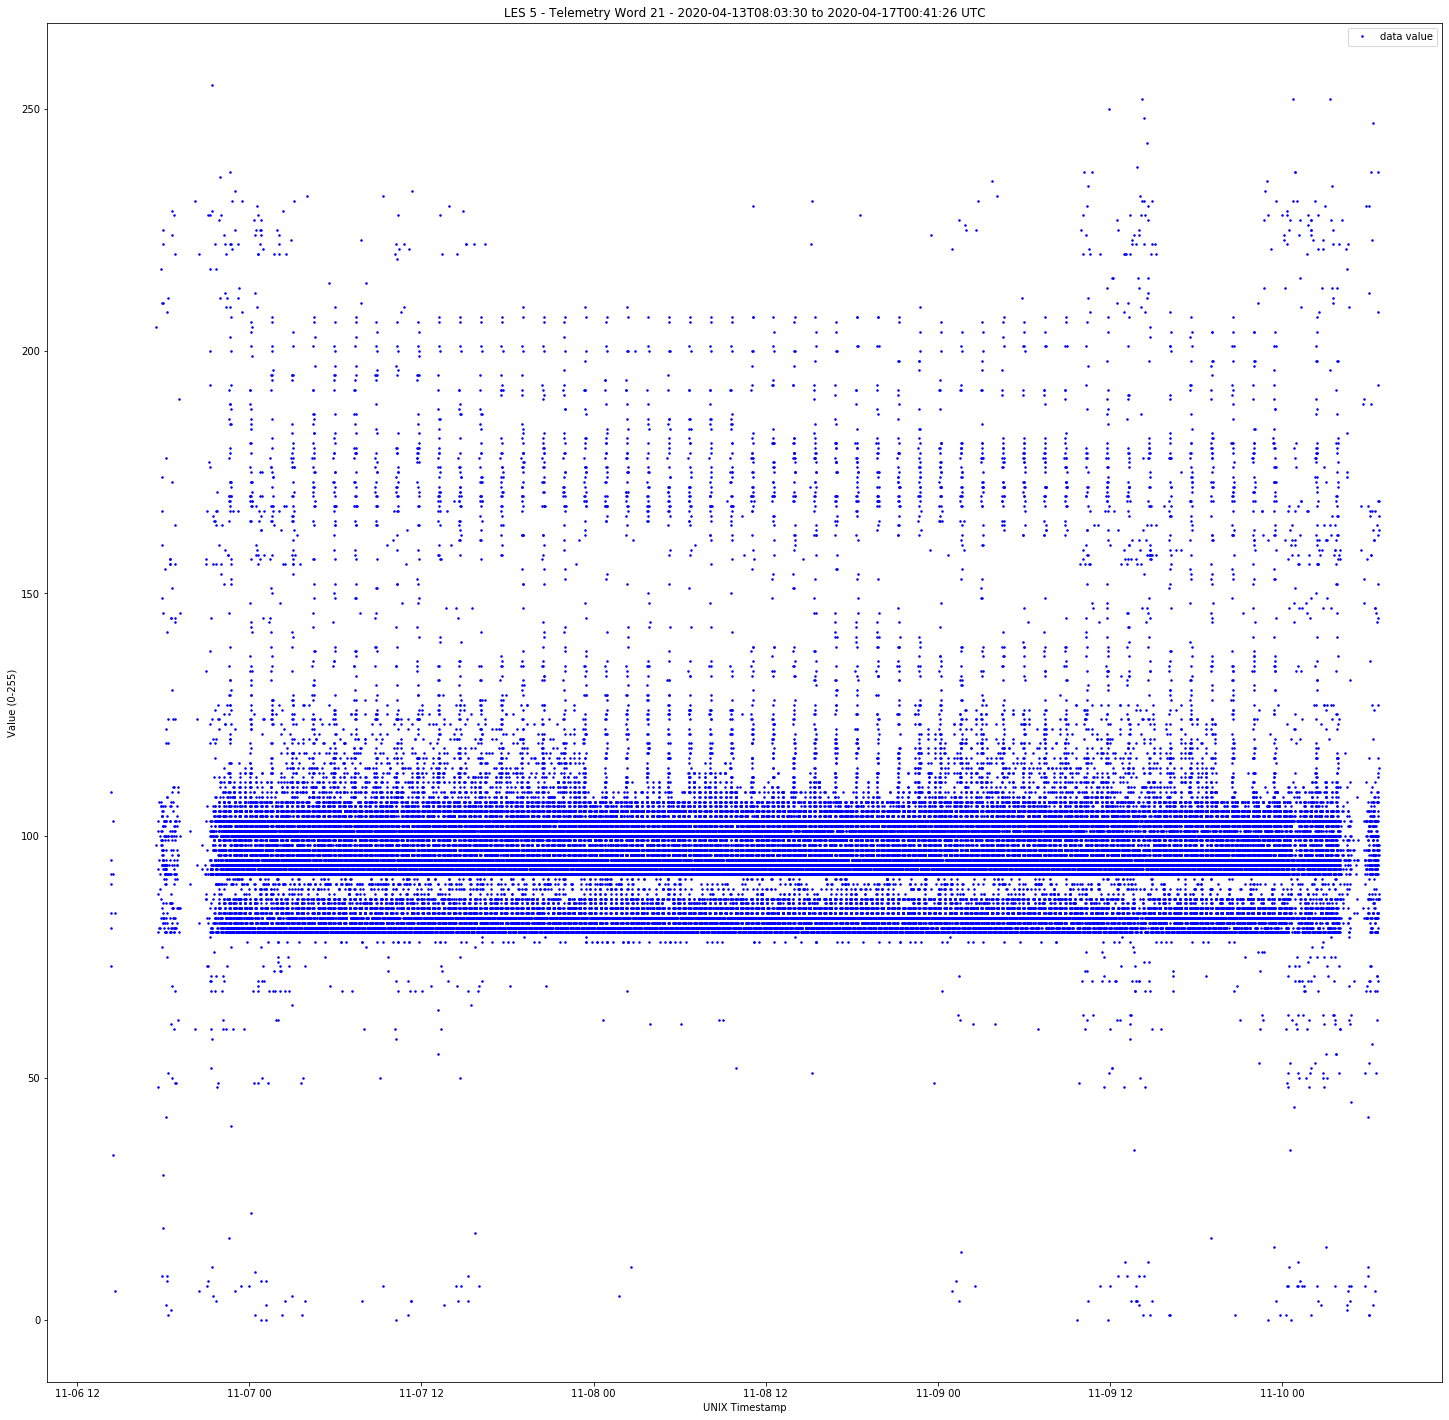

In [13]:
# RFI Experiment Channels

plt.figure(figsize = [25,25])
plt.plot(t, word_21, '.', markersize=3, alpha=1, color='blue')
plt.title('LES 5 - Telemetry Word 21 - 2020-04-13T08:03:30 to 2020-04-17T00:41:26 UTC')
plt.xlabel('UNIX Timestamp')
plt.ylabel('Value (0-255)')
plt.legend(['data value']);

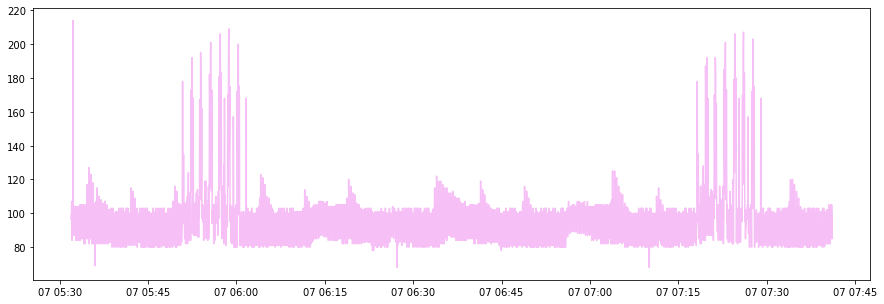

In [14]:
plt.figure(figsize = [X,Y])
plt.plot(t[10000:13000], word_21[10000:13000], markersize=.1, alpha=.5, color=ZOOMED_DATA_WORD_COLOR);

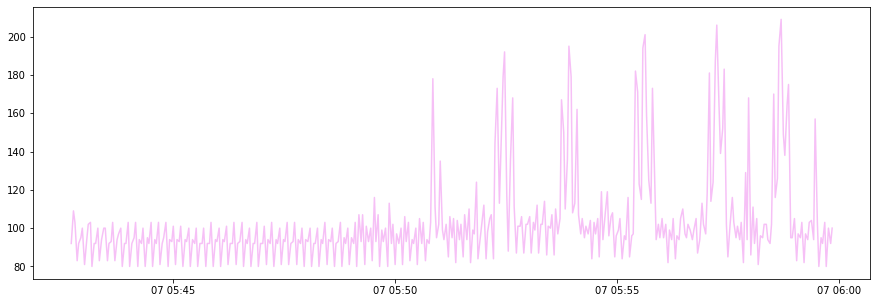

In [15]:
plt.figure(figsize = [X,Y])
plt.plot(t[10250:10650], word_21[10250:10650], markersize=.1, alpha=.5, color=ZOOMED_DATA_WORD_COLOR);

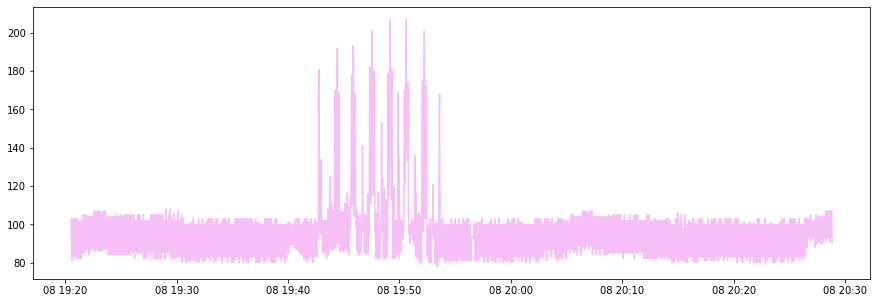

In [16]:
plt.figure(figsize = [X,Y])
plt.plot(t[62400:64000], word_21[62400:64000], markersize=.1, alpha=.5, color=ZOOMED_DATA_WORD_COLOR);

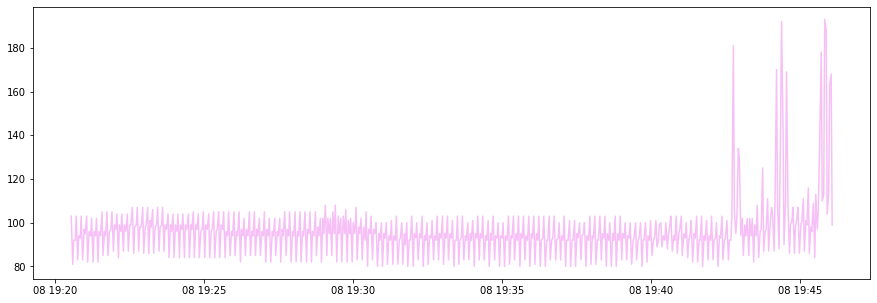

In [17]:
plt.figure(figsize = [X,Y])
plt.plot(t[62400:63000], word_21[62400:63000], markersize=.1, alpha=.5, color=ZOOMED_DATA_WORD_COLOR);

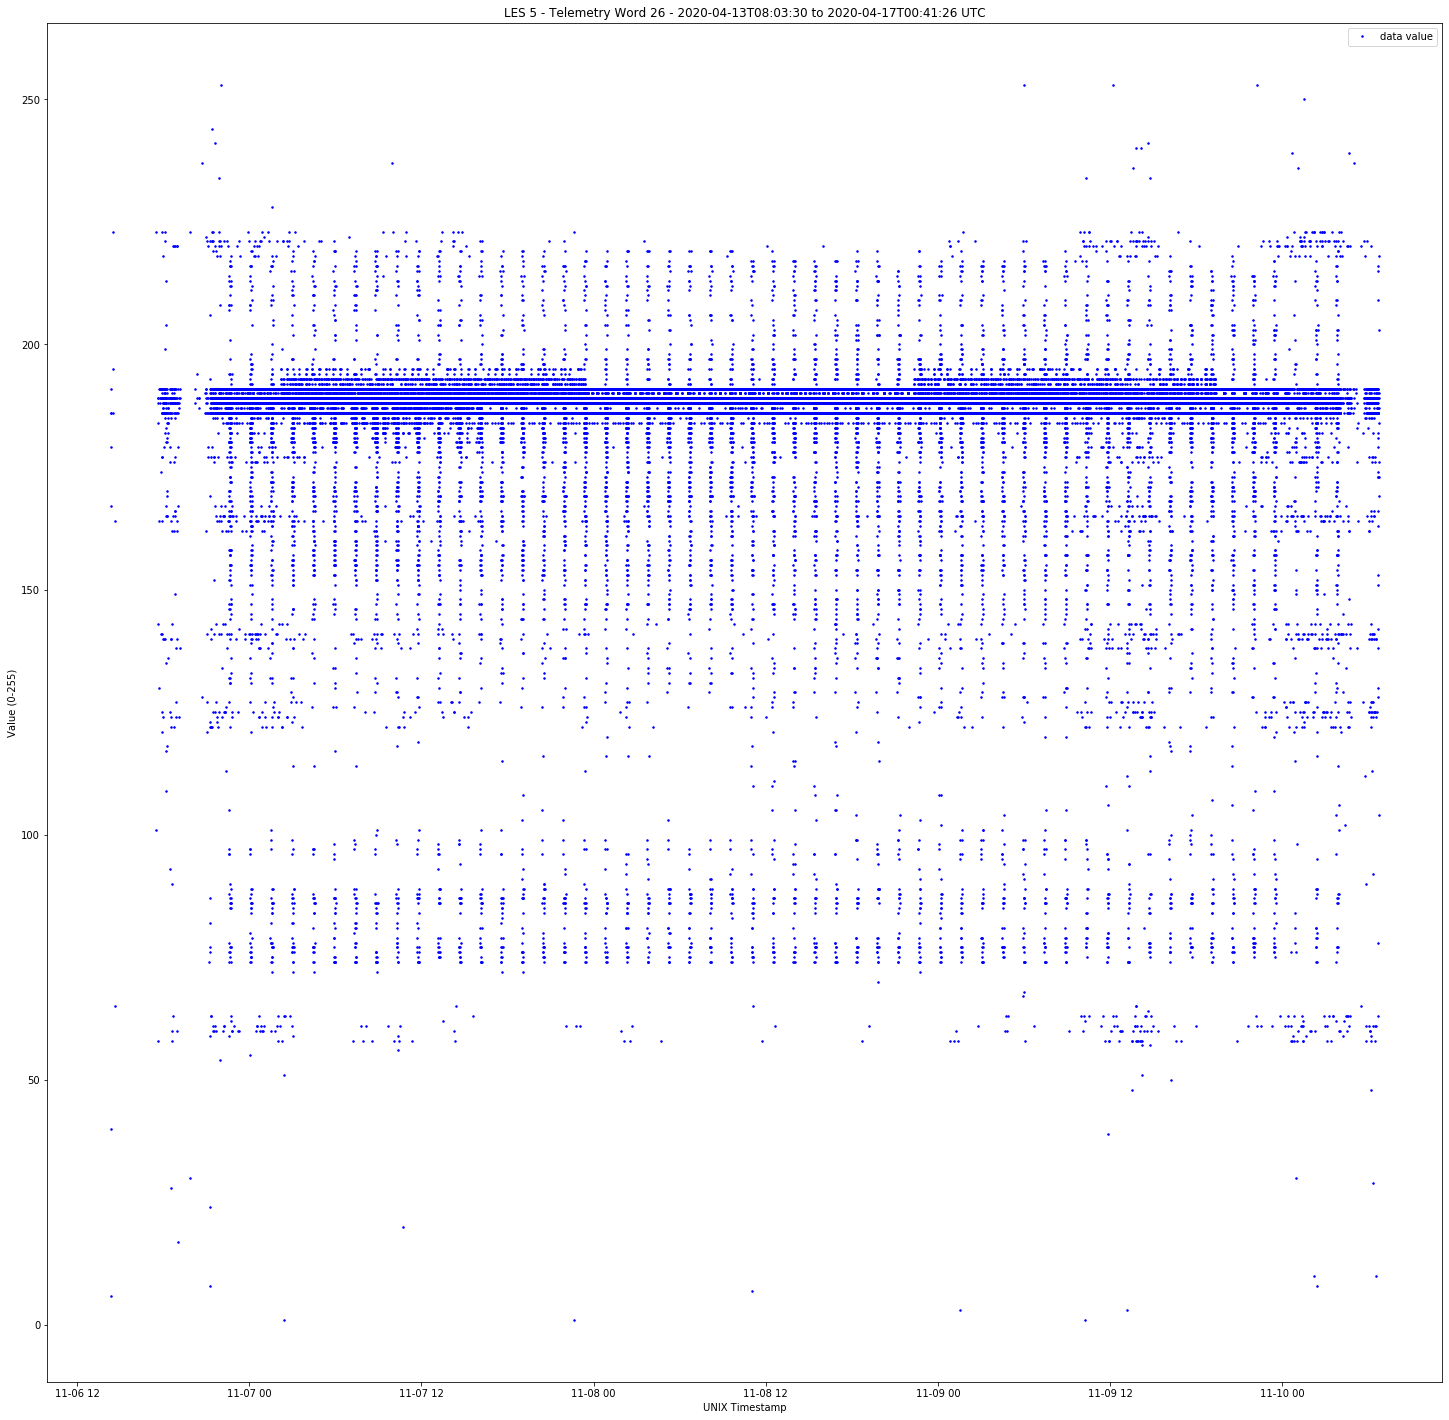

In [18]:
plt.figure(figsize = [25,25])
plt.plot(t, word_26, '.', markersize=3, alpha=1, color='blue')
plt.title('LES 5 - Telemetry Word 26 - 2020-04-13T08:03:30 to 2020-04-17T00:41:26 UTC')
plt.xlabel('UNIX Timestamp')
plt.ylabel('Value (0-255)')
plt.legend(['data value']);

In [19]:
#FRAME 0 data words
x = 0

frame0_word_0 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_1 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_2 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_3 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_4 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_5 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_6 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_7 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_8 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_9 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_10 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_11 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_12 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_13 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_14 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_15 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_16 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_17 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_18 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_19 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_20 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_21 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_22 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_23 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_24 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_25 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_26 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_27 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_28 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_29 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_30 = np.arange(frame0_count).reshape(frame0_count,1)
frame0_word_31 = np.arange(frame0_count).reshape(frame0_count,1)

for x in range (0,frame0_count):
    frame0_word_0[x] = frame0_words[x,0]
    frame0_word_1[x] = frame0_words[x,1]
    frame0_word_2[x] = frame0_words[x,2]
    frame0_word_3[x] = frame0_words[x,3]
    frame0_word_4[x] = frame0_words[x,4]
    frame0_word_5[x] = frame0_words[x,5]
    frame0_word_6[x] = frame0_words[x,6]
    frame0_word_7[x] = frame0_words[x,7]
    frame0_word_8[x] = frame0_words[x,8]
    frame0_word_9[x] = frame0_words[x,9]
    frame0_word_10[x] = frame0_words[x,10]
    frame0_word_11[x] = frame0_words[x,11]
    frame0_word_12[x] = frame0_words[x,12]
    frame0_word_13[x] = frame0_words[x,13]
    frame0_word_14[x] = frame0_words[x,14]
    frame0_word_15[x] = frame0_words[x,15]
    frame0_word_16[x] = frame0_words[x,16]
    frame0_word_17[x] = frame0_words[x,17]
    frame0_word_18[x] = frame0_words[x,18]
    frame0_word_19[x] = frame0_words[x,19]
    frame0_word_20[x] = frame0_words[x,20]
    frame0_word_21[x] = frame0_words[x,21]
    frame0_word_22[x] = frame0_words[x,22]
    frame0_word_23[x] = frame0_words[x,23]
    frame0_word_24[x] = frame0_words[x,24]
    frame0_word_25[x] = frame0_words[x,25]
    frame0_word_26[x] = frame0_words[x,26]
    frame0_word_27[x] = frame0_words[x,27]
    frame0_word_28[x] = frame0_words[x,28]
    frame0_word_29[x] = frame0_words[x,29]
    frame0_word_30[x] = frame0_words[x,30]
    frame0_word_31[x] = frame0_words[x,31]  

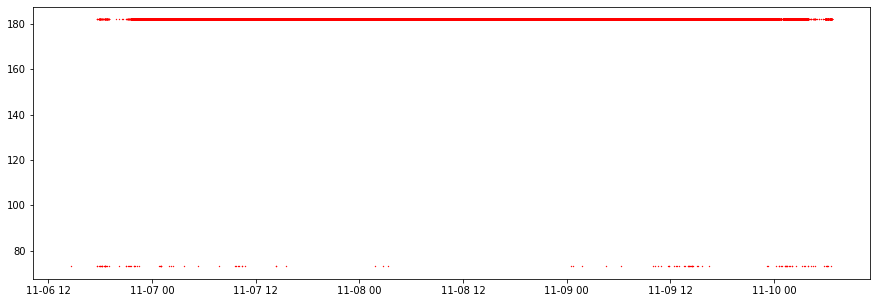

In [20]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_0, '.', markersize=MARKERSIZE, alpha=ALPHA, color=SYNC_COLOR);

10001000
[136]


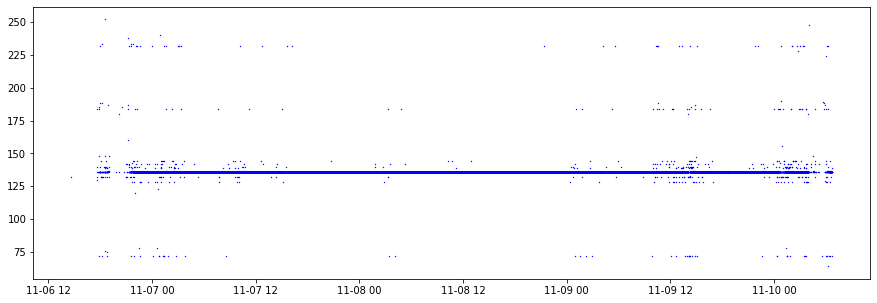

In [21]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_1, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);
print("{0:08b}".format((frame0_word_1[10000,0])))
print(frame0_word_1[10000])

01000000
[64]


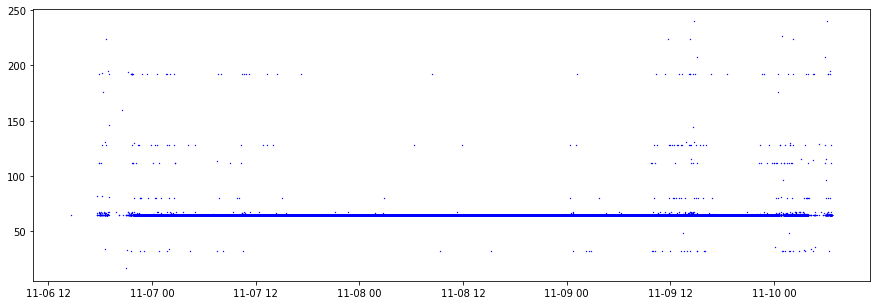

In [22]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_2, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);
print("{0:08b}".format((frame0_word_2[10000,0])))
print(frame0_word_2[10001])

00100100
[36]


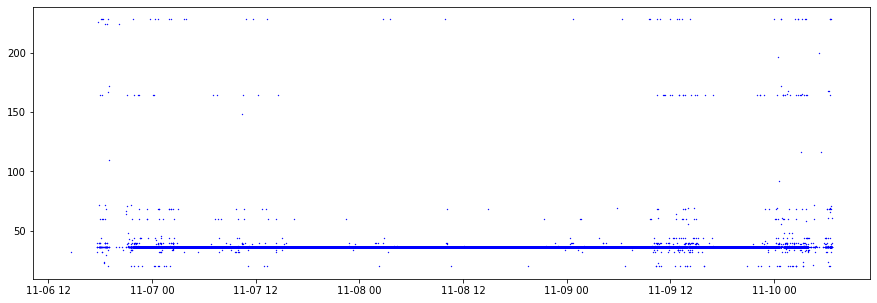

In [23]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_3, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);
print("{0:08b}".format((frame0_word_3[10000,0])))
print(frame0_word_3[10000])

00000000
[246]


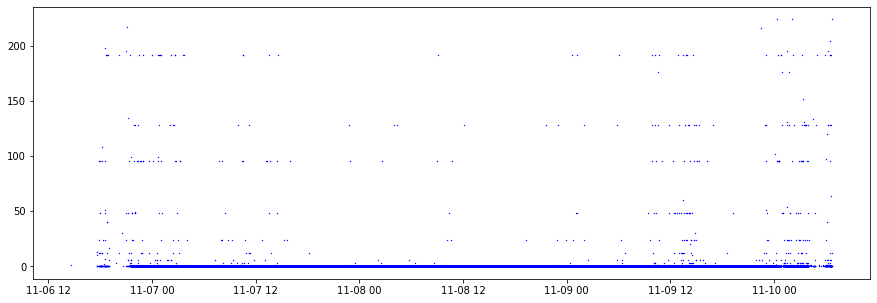

In [24]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_4, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);
print("{0:08b}".format((frame0_word_4[10000,0])))
print(frame0_word_5[10000])

11110110
[246]


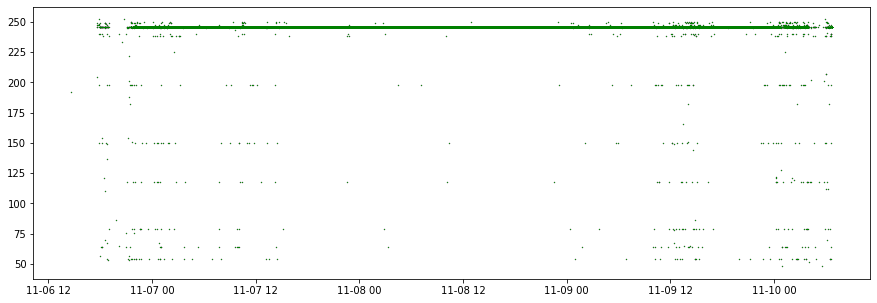

In [25]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_5, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);
print("{0:08b}".format((frame0_word_5[10000,0])))
print(frame0_word_5[10000])

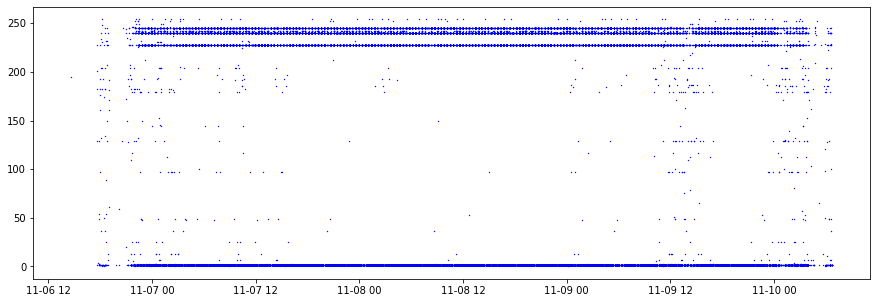

In [26]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_6, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

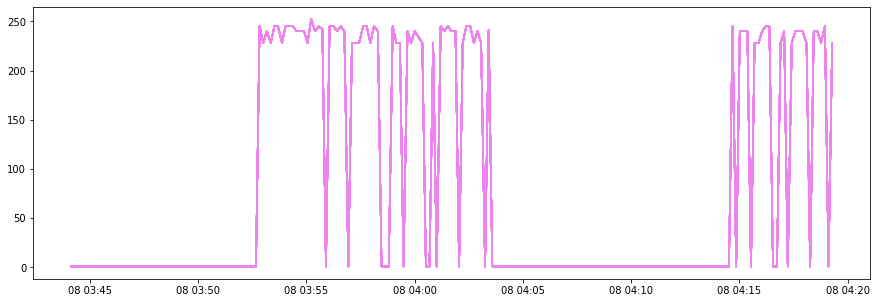

In [27]:
plt.figure(figsize = [X,Y])
plt.plot(t0[10000:10200], frame0_word_6[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

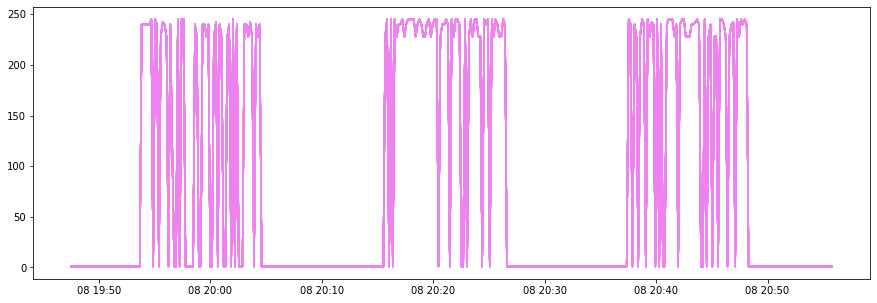

In [28]:
plt.figure(figsize = [X,Y])
plt.plot(t0[15600:16000], frame0_word_6[15600:16000], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

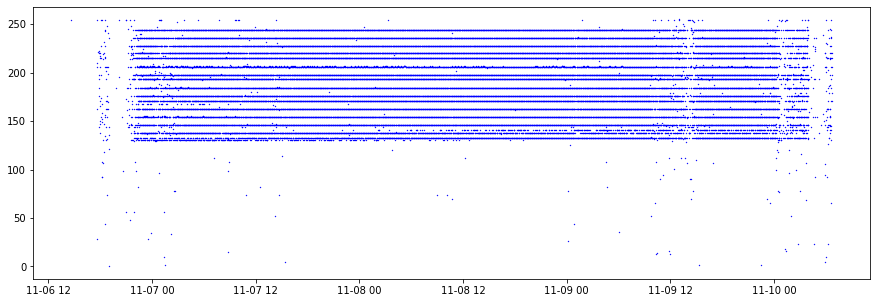

In [29]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_7, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

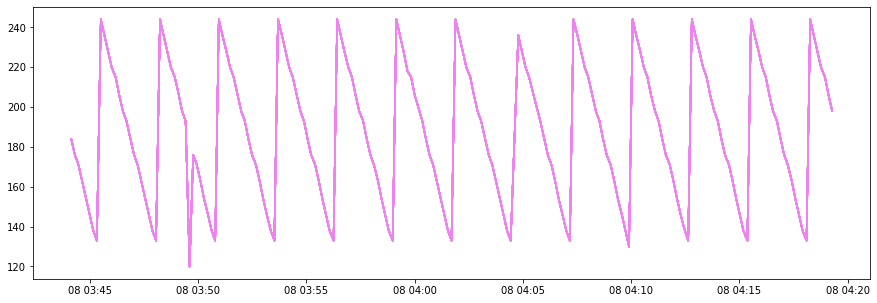

In [30]:
plt.figure(figsize = [X,Y])
plt.plot(t0[10000:10200], frame0_word_7[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

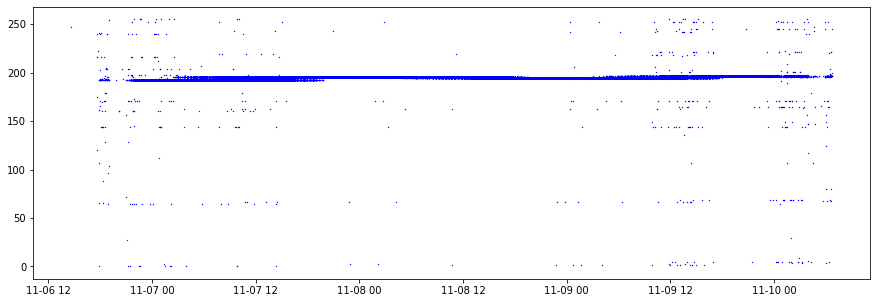

In [31]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_8, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

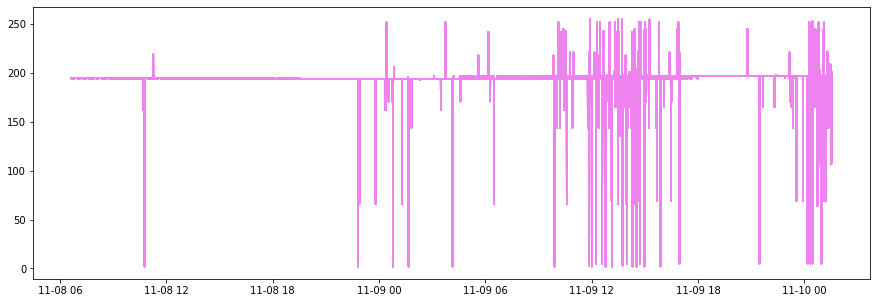

In [32]:
plt.figure(figsize = [X,Y])
plt.plot(t0[11000:25000], frame0_word_8[11000:25000], markersize=.1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

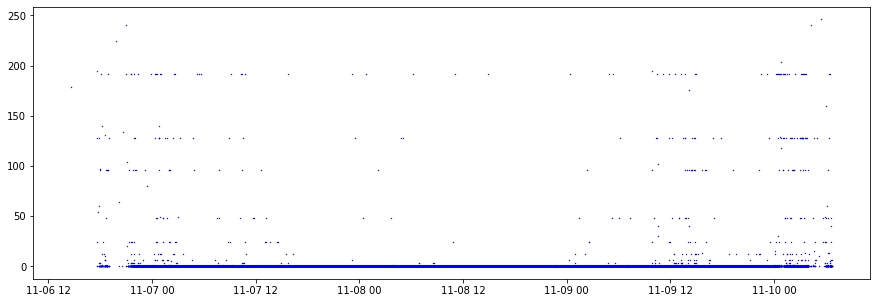

In [33]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_9, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

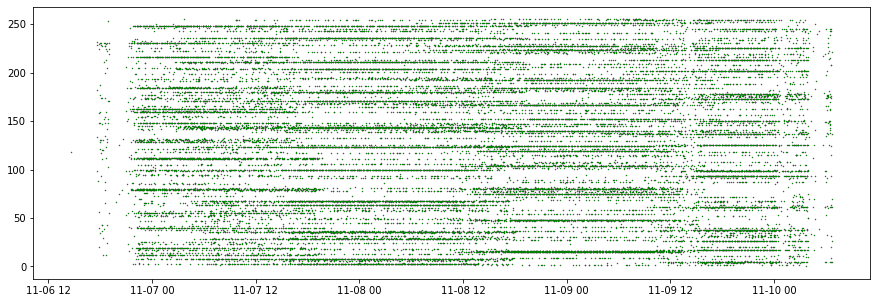

In [34]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_10, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

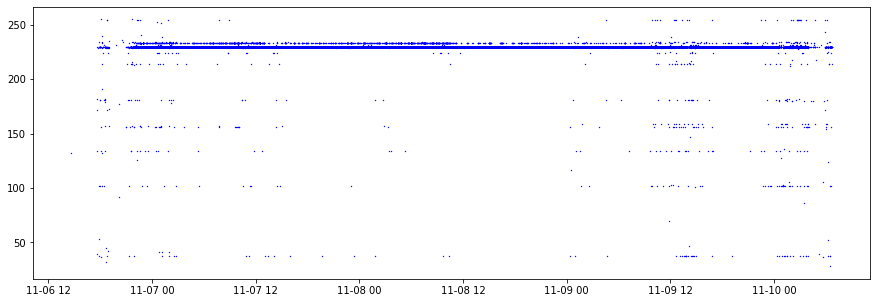

In [35]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_11, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

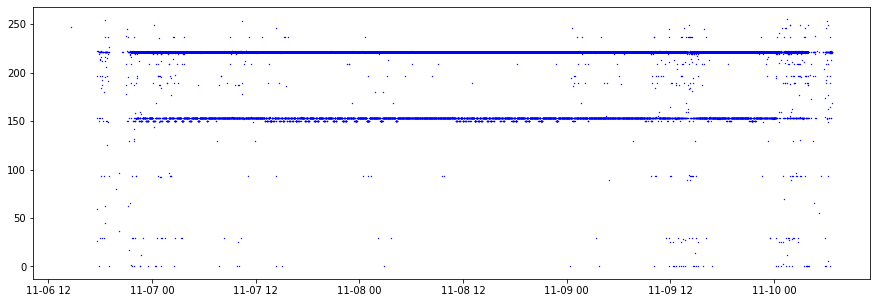

In [36]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_12, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

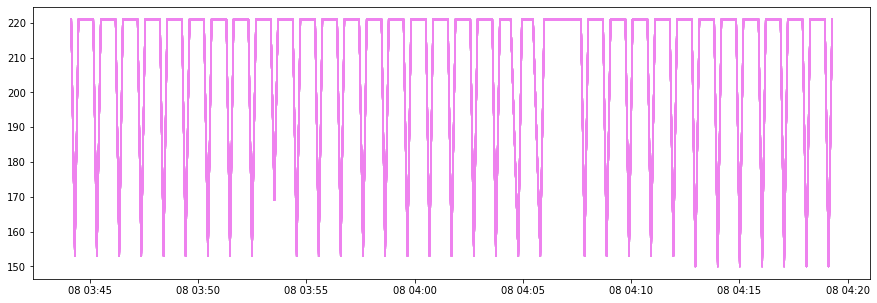

In [37]:
plt.figure(figsize = [X,Y])
plt.plot(t0[10000:10200], frame0_word_12[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

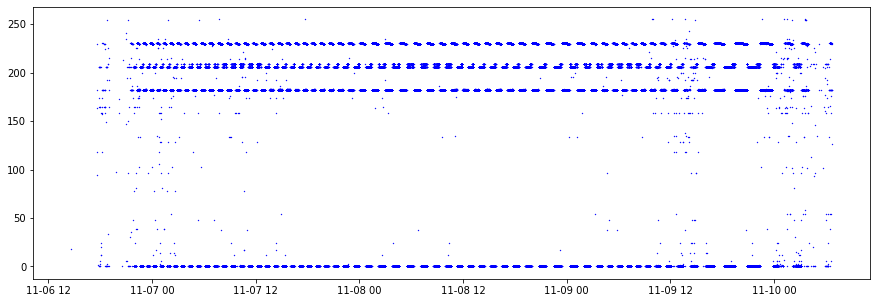

In [38]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_13, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

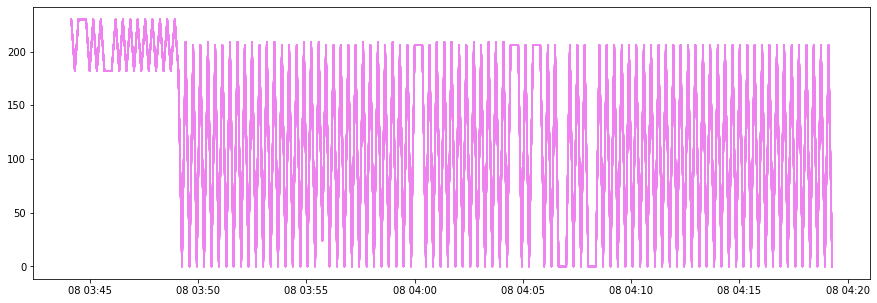

In [39]:
plt.figure(figsize = [X,Y])
plt.plot(t0[10000:10200], frame0_word_13[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

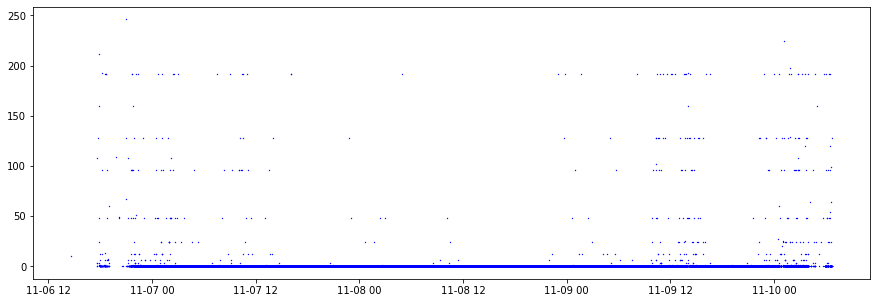

In [40]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_14, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

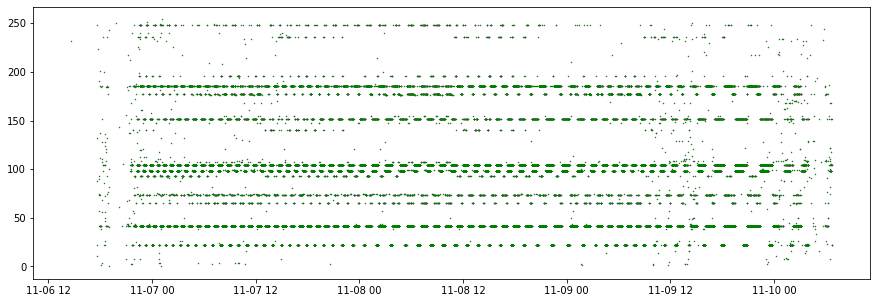

In [41]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_15, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

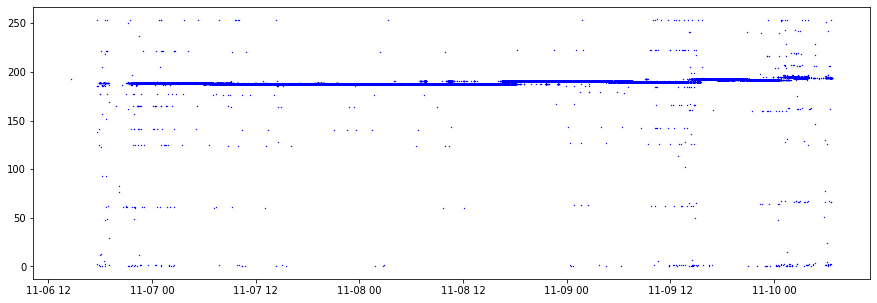

In [42]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_16, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

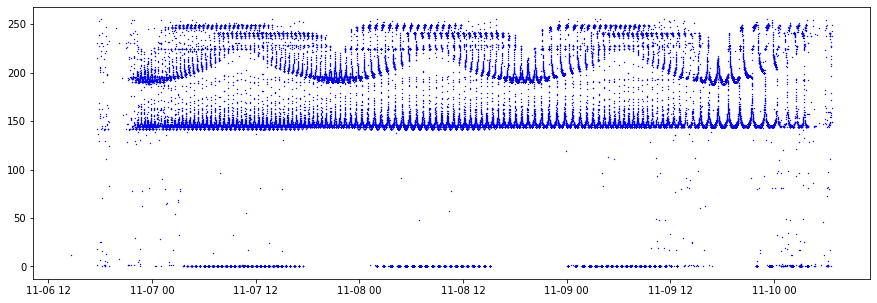

In [43]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_17, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

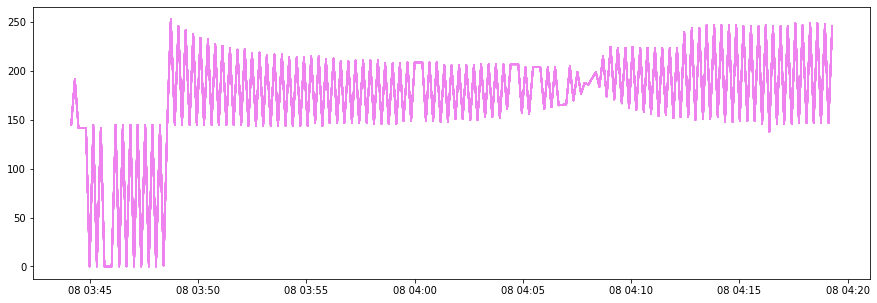

In [44]:
plt.figure(figsize = [X,Y])
plt.plot(t0[10000:10200], frame0_word_17[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

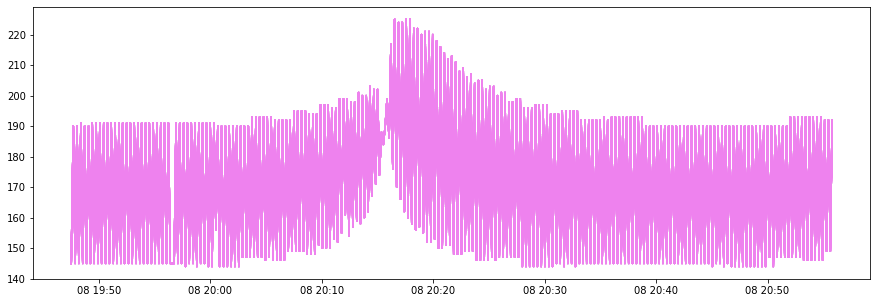

In [45]:
plt.figure(figsize = [X,Y])
plt.plot(t0[15600:16000], frame0_word_17[15600:16000], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

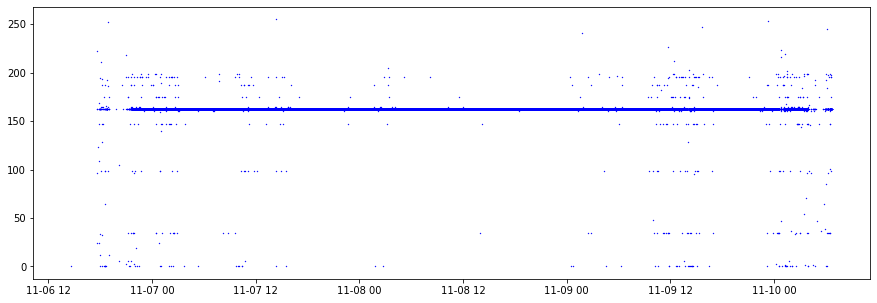

In [46]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_18, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

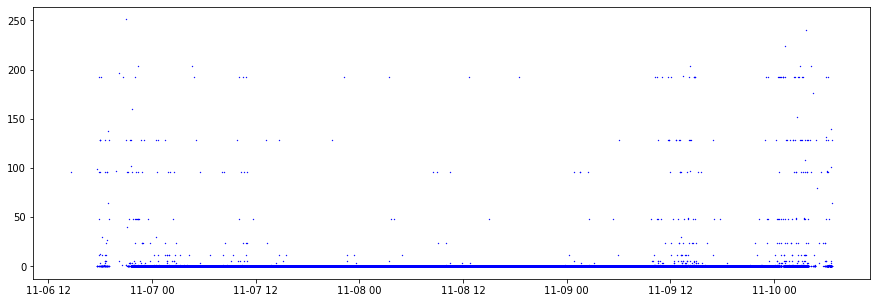

In [47]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_19, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

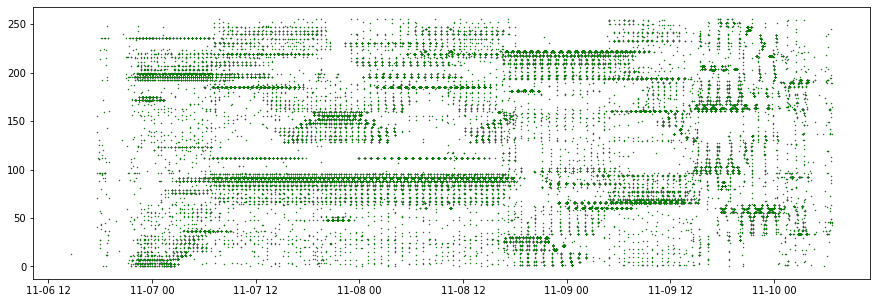

In [48]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_20, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

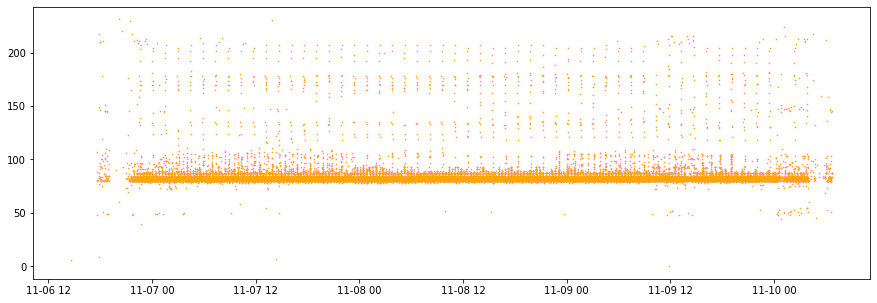

In [49]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_21, '.', markersize=MARKERSIZE, alpha=ALPHA, color=RFI_EXPERIEMNT_DATA_COLOR);

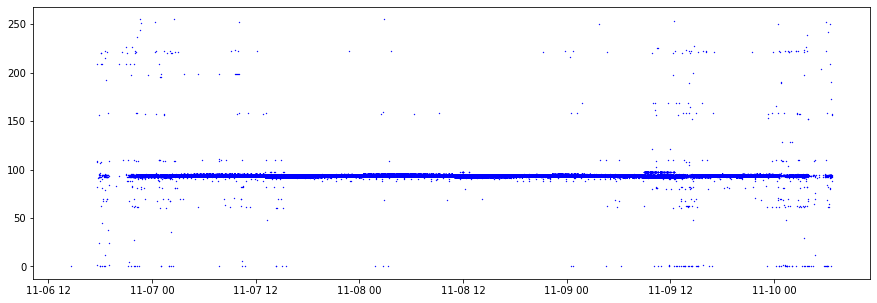

In [50]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_22, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

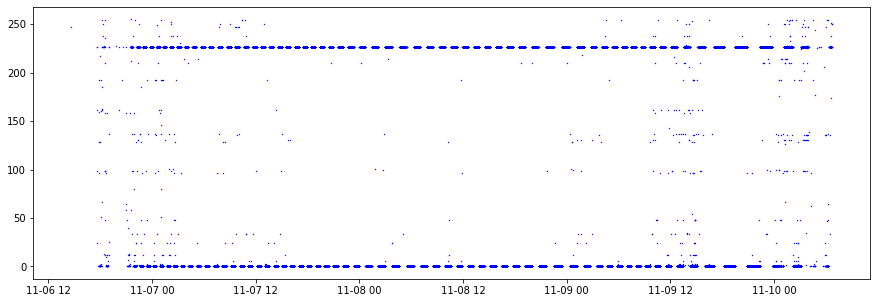

In [51]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_23, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

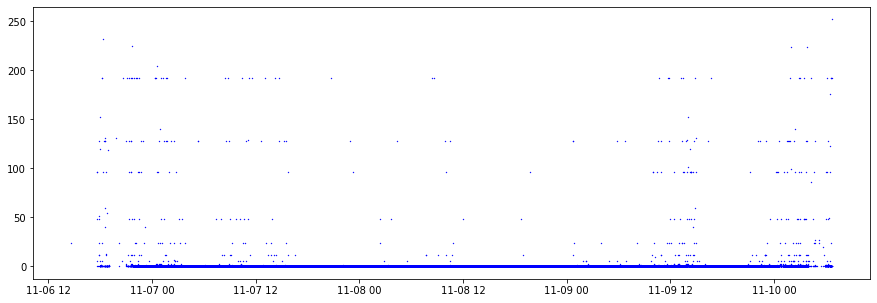

In [52]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_24, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

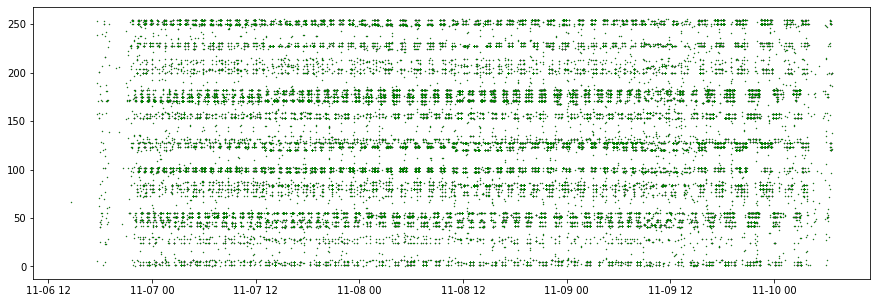

In [53]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_25, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

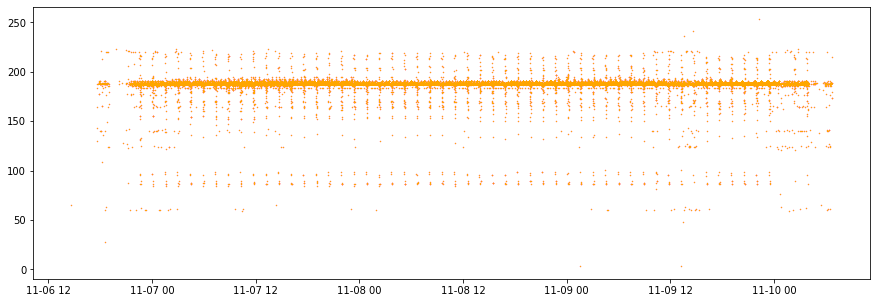

In [54]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_26, '.', markersize=MARKERSIZE, alpha=ALPHA, color=RFI_EXPERIEMNT_DATA_COLOR);

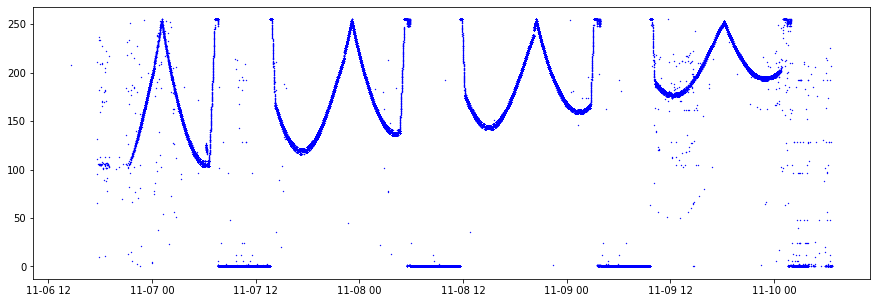

In [55]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_27, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

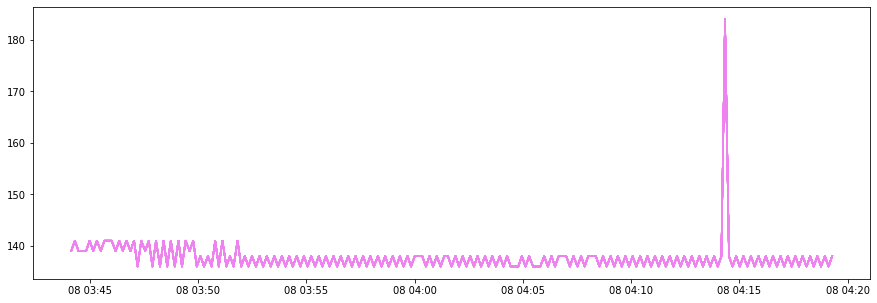

In [56]:
plt.figure(figsize = [X,Y])
plt.plot(t0[10000:10200], frame0_word_27[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

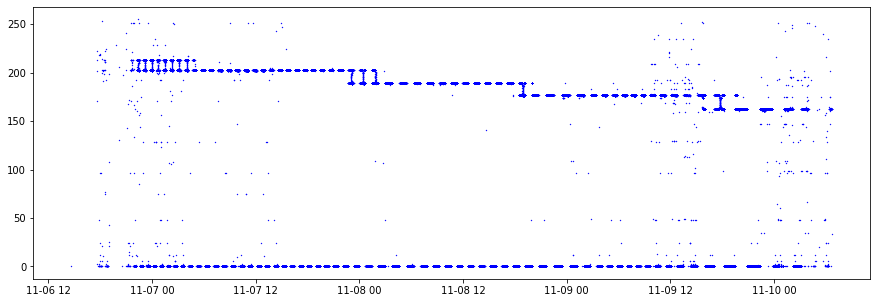

In [57]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_28, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

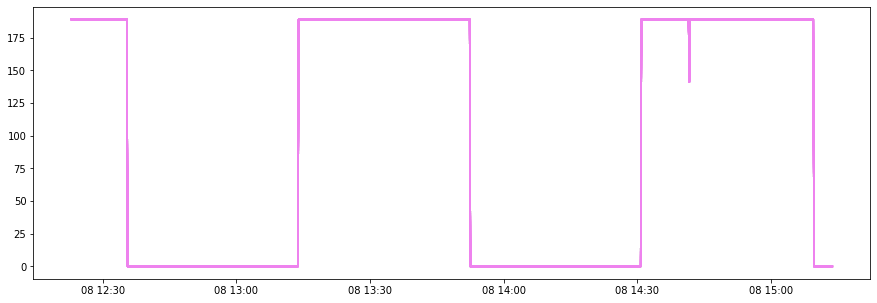

In [58]:
plt.figure(figsize = [X,Y])
plt.plot(t0[13000:14000], frame0_word_28[13000:14000], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);


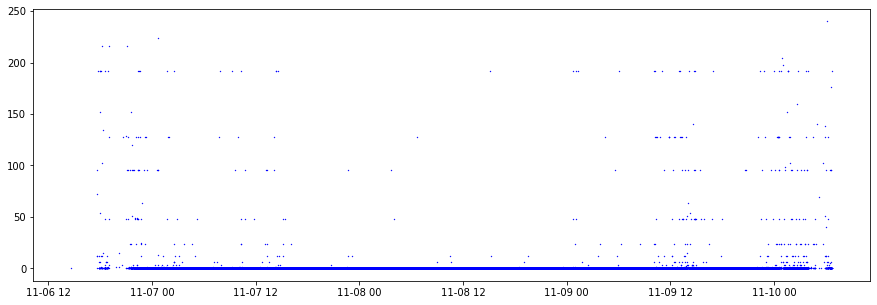

In [59]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_29, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

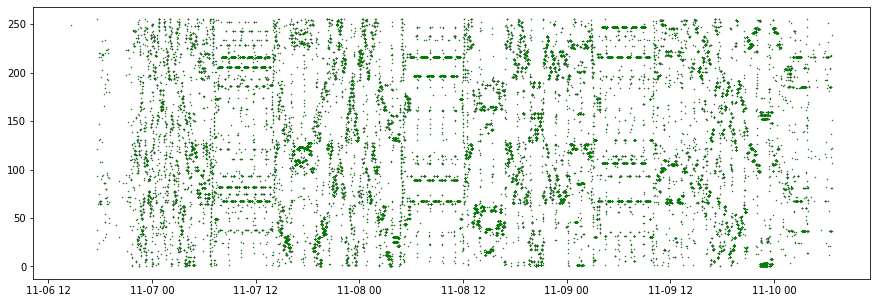

In [60]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_30, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

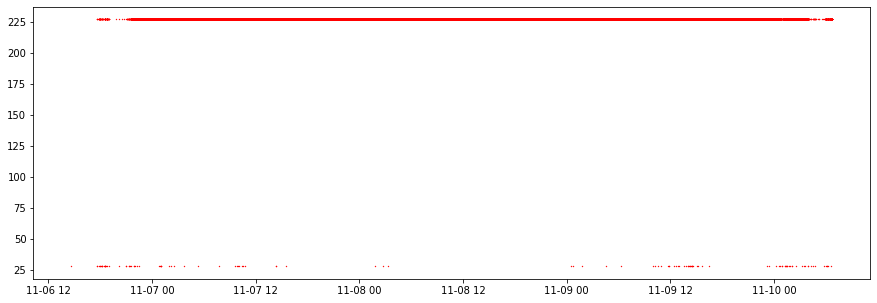

In [61]:
plt.figure(figsize = [X,Y])
plt.plot(t0, frame0_word_31, '.', markersize=MARKERSIZE, alpha=ALPHA, color=SYNC_COLOR);

In [62]:
#FRAME 1 data words
x = 0

frame1_word_0 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_1 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_2 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_3 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_4 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_5 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_6 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_7 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_8 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_9 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_10 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_11 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_12 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_13 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_14 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_15 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_16 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_17 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_18 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_19 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_20 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_21 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_22 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_23 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_24 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_25 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_26 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_27 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_28 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_29 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_30 = np.arange(frame1_count).reshape(frame1_count,1)
frame1_word_31 = np.arange(frame1_count).reshape(frame1_count,1)

for x in range (0,frame1_count):
    frame1_word_0[x] = frame1_words[x,0]
    frame1_word_1[x] = frame1_words[x,1]
    frame1_word_2[x] = frame1_words[x,2]
    frame1_word_3[x] = frame1_words[x,3]
    frame1_word_4[x] = frame1_words[x,4]
    frame1_word_5[x] = frame1_words[x,5]
    frame1_word_6[x] = frame1_words[x,6]
    frame1_word_7[x] = frame1_words[x,7]
    frame1_word_8[x] = frame1_words[x,8]
    frame1_word_9[x] = frame1_words[x,9]
    frame1_word_10[x] = frame1_words[x,10]
    frame1_word_11[x] = frame1_words[x,11]
    frame1_word_12[x] = frame1_words[x,12]
    frame1_word_13[x] = frame1_words[x,13]
    frame1_word_14[x] = frame1_words[x,14]
    frame1_word_15[x] = frame1_words[x,15]
    frame1_word_16[x] = frame1_words[x,16]
    frame1_word_17[x] = frame1_words[x,17]
    frame1_word_18[x] = frame1_words[x,18]
    frame1_word_19[x] = frame1_words[x,19]
    frame1_word_20[x] = frame1_words[x,20]
    frame1_word_21[x] = frame1_words[x,21]
    frame1_word_22[x] = frame1_words[x,22]
    frame1_word_23[x] = frame1_words[x,23]
    frame1_word_24[x] = frame1_words[x,24]
    frame1_word_25[x] = frame1_words[x,25]
    frame1_word_26[x] = frame1_words[x,26]
    frame1_word_27[x] = frame1_words[x,27]
    frame1_word_28[x] = frame1_words[x,28]
    frame1_word_29[x] = frame1_words[x,29]
    frame1_word_30[x] = frame1_words[x,30]
    frame1_word_31[x] = frame1_words[x,31]  
    

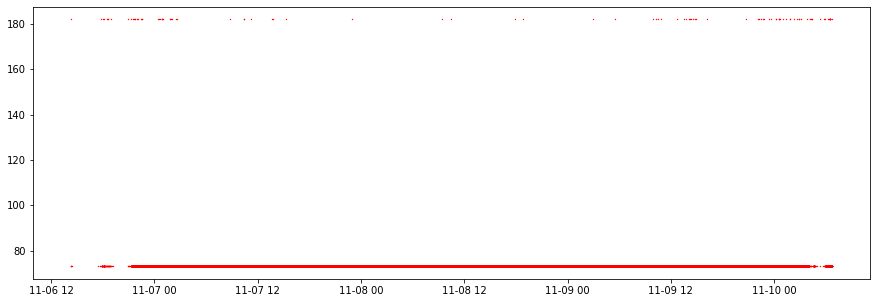

In [63]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_0, '.', markersize=MARKERSIZE, alpha=ALPHA, color=SYNC_COLOR);

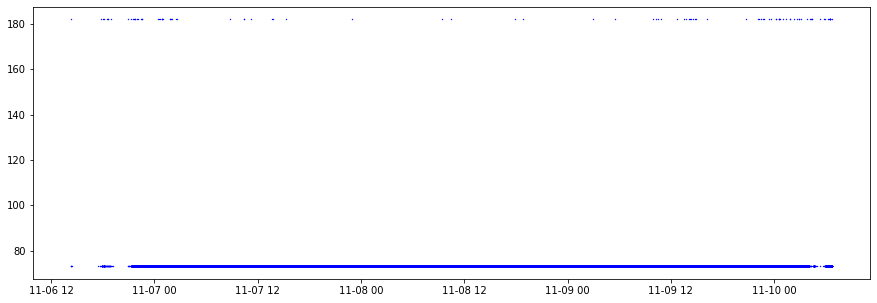

In [64]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_0, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

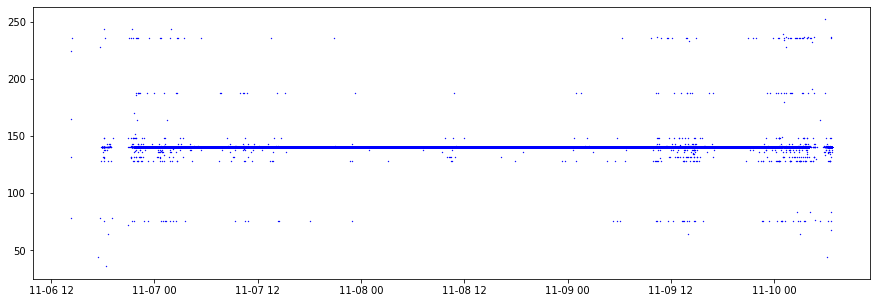

In [65]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_1, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

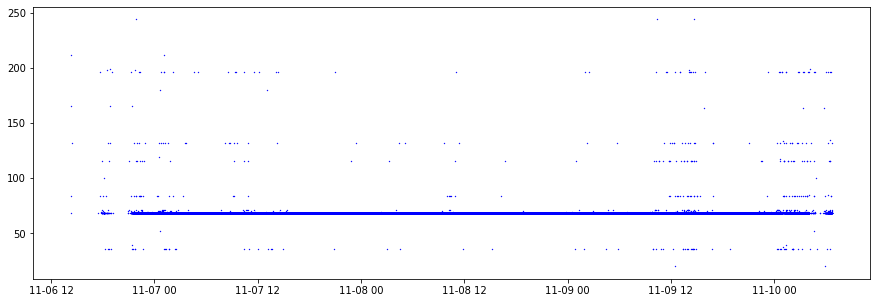

In [66]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_2, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

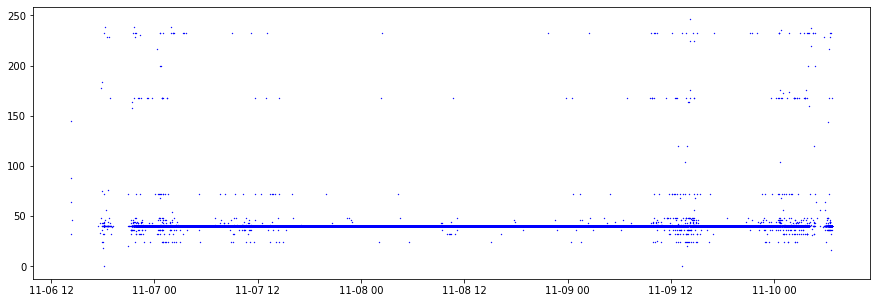

In [67]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_3, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

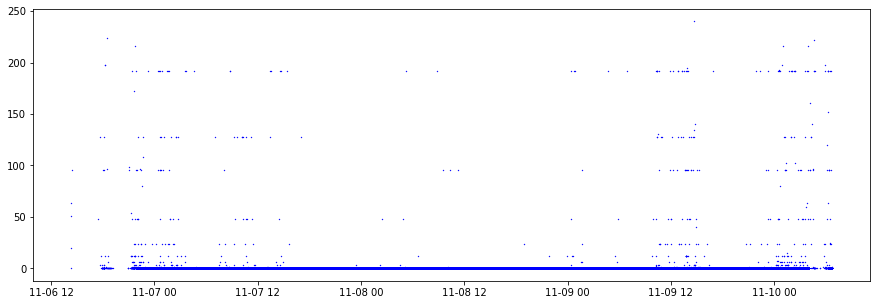

In [68]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_4, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

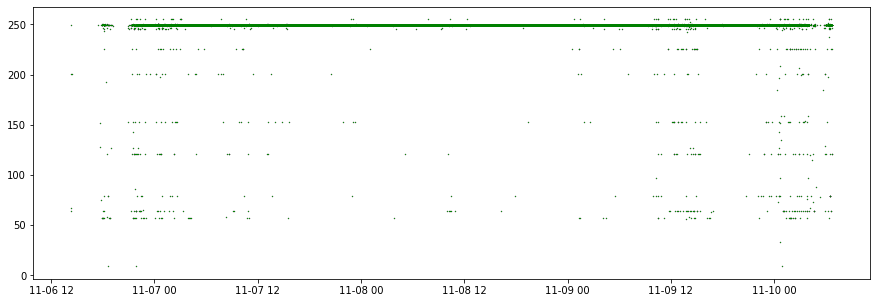

In [69]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_5, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

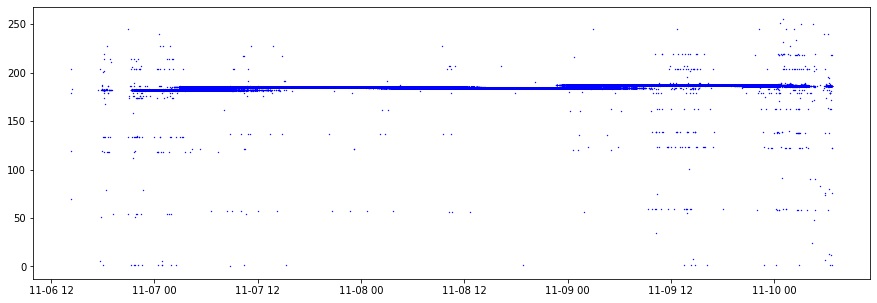

In [70]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_6, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

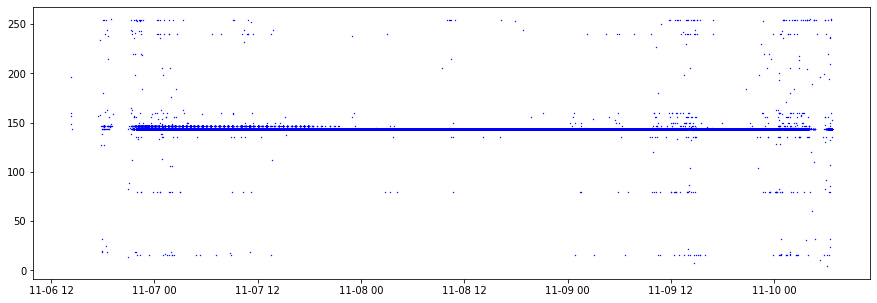

In [71]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_7, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

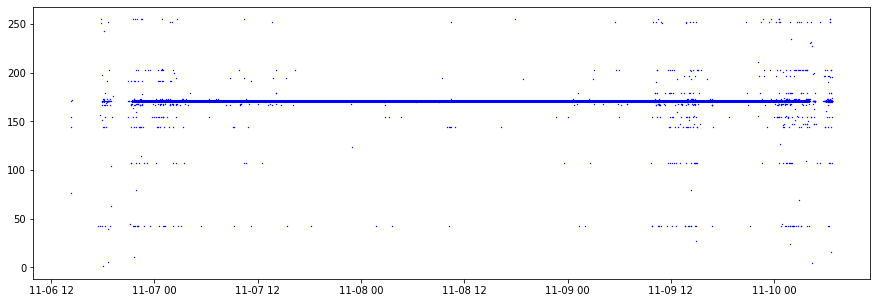

In [72]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_8, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

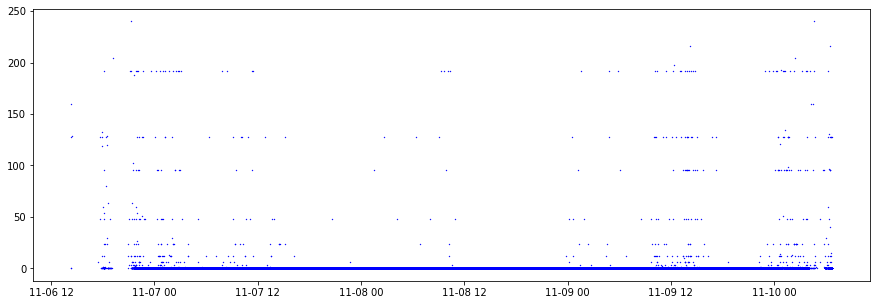

In [73]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_9, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

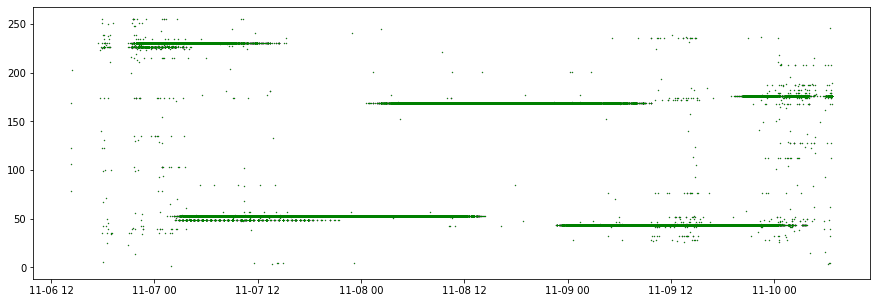

In [74]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_10, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

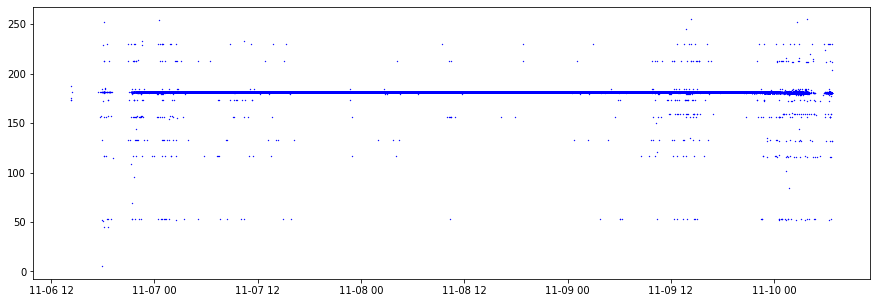

In [75]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_11, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

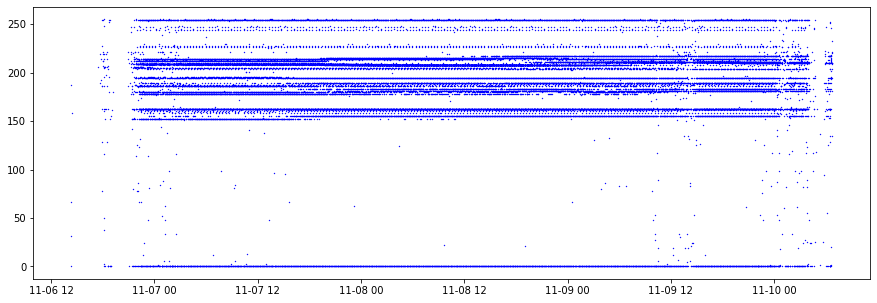

In [76]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_12, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

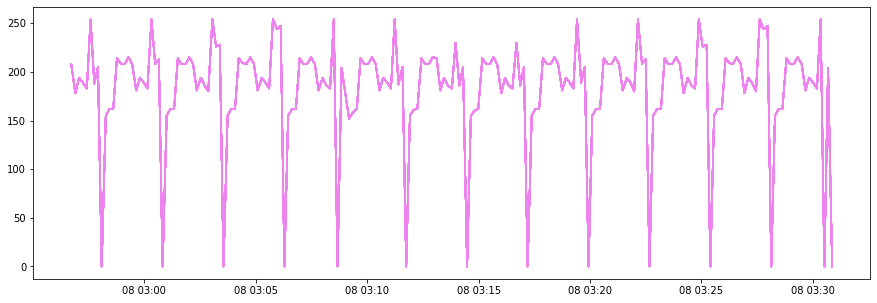

In [77]:
plt.figure(figsize = [X,Y])
plt.plot(t1[10000:10200], frame1_word_12[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

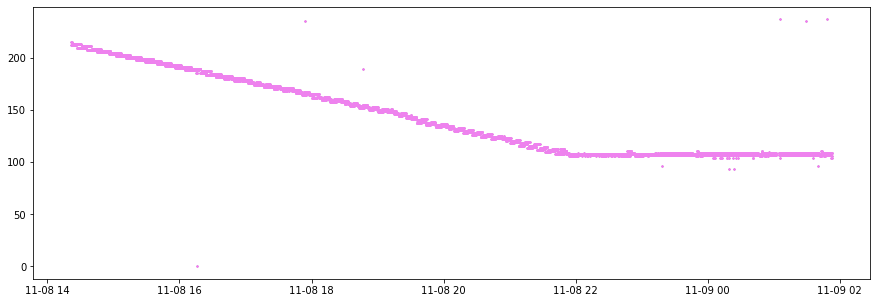

In [78]:
plt.figure(figsize = [X,Y])
plt.plot(t1[14000:18000], frame1_word_28[14000:18000], '.',markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

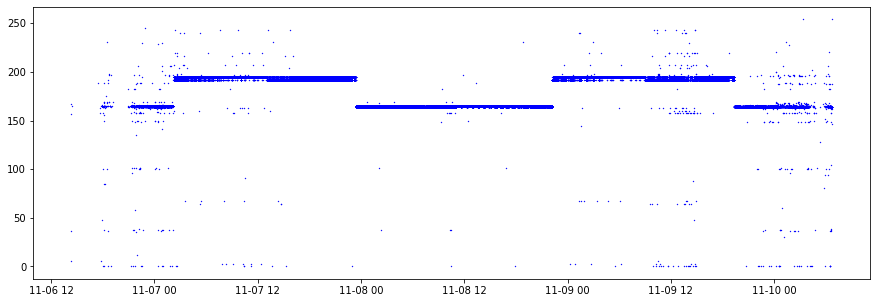

In [79]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_13, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

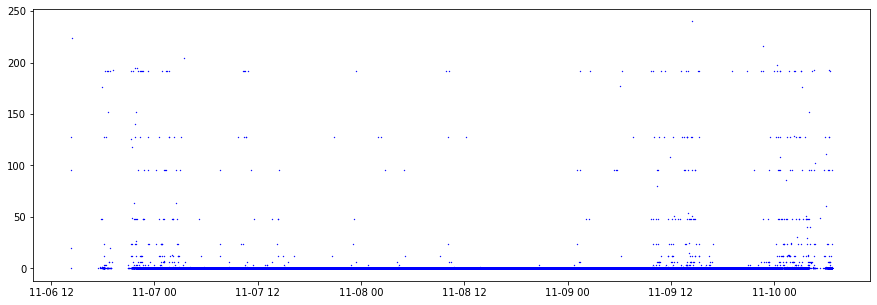

In [80]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_14, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

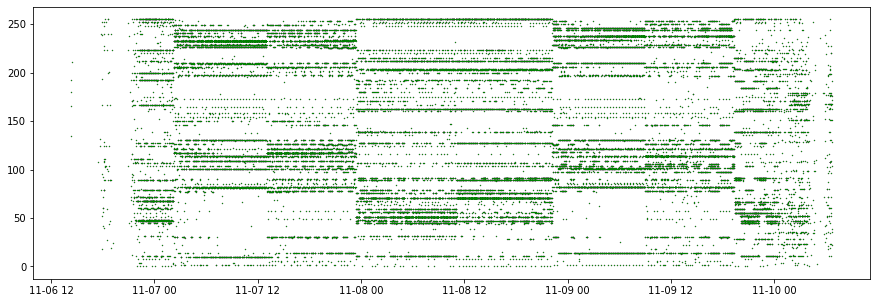

In [81]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_15, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

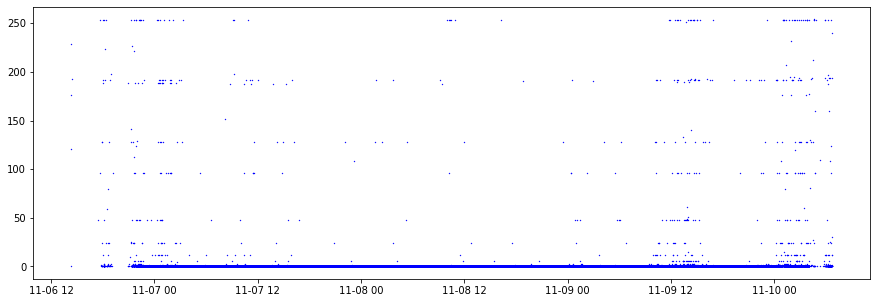

In [82]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_16, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

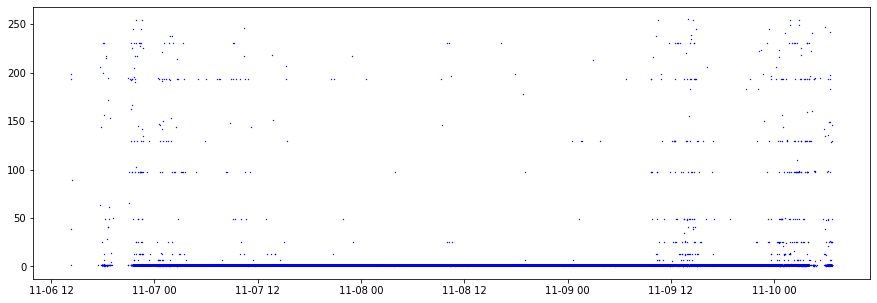

In [83]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_17, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

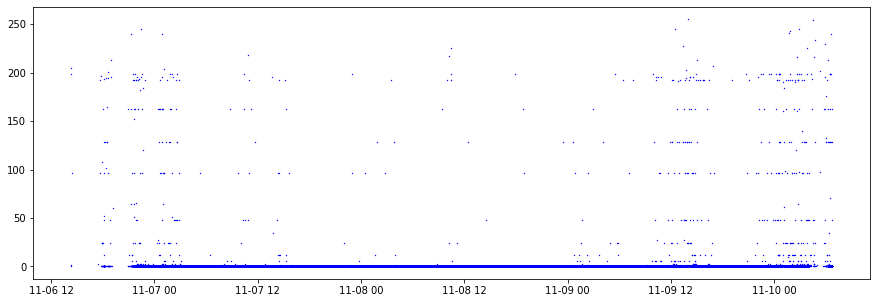

In [84]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_18, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

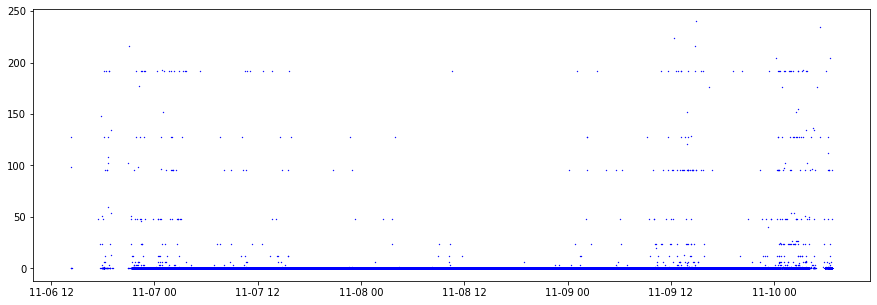

In [85]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_19, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

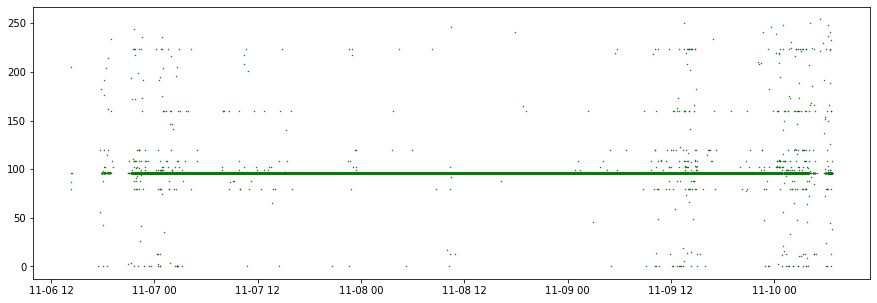

In [86]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_20, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

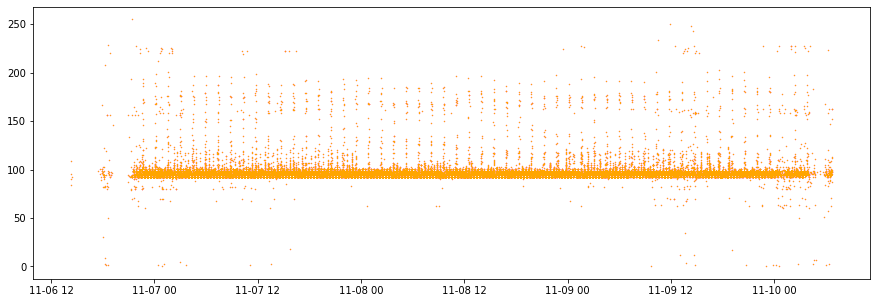

In [87]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_21, '.', markersize=MARKERSIZE, alpha=ALPHA, color=RFI_EXPERIEMNT_DATA_COLOR);

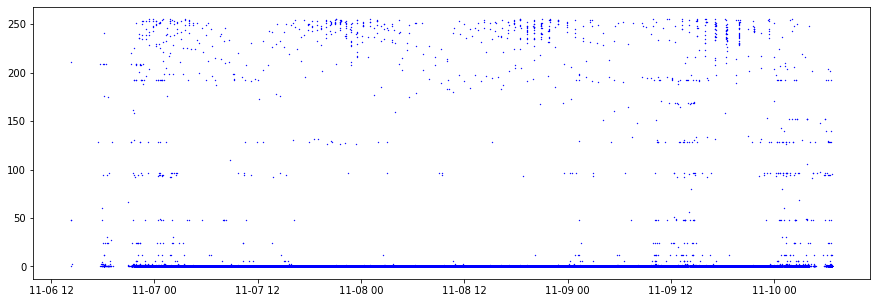

In [88]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_22, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

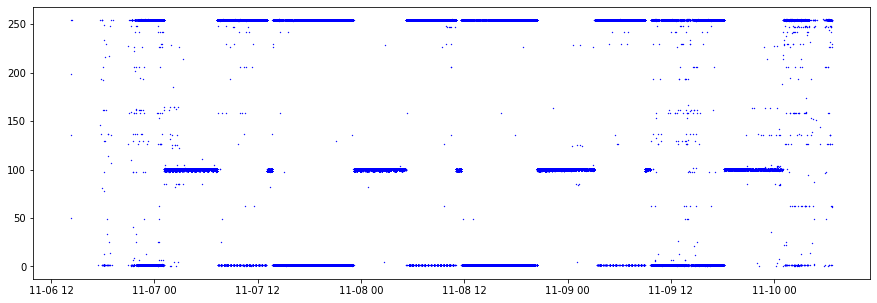

In [89]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_23, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

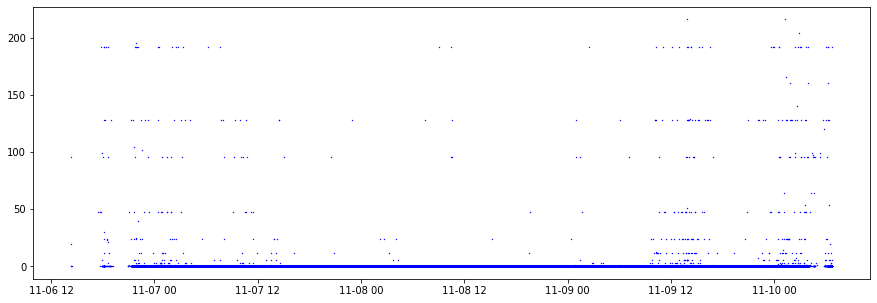

In [90]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_24, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

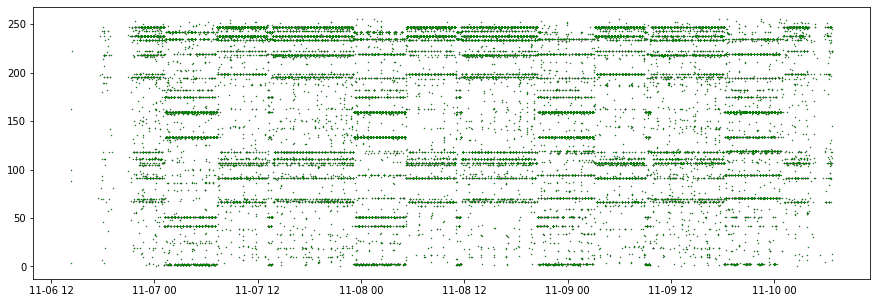

In [91]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_25, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

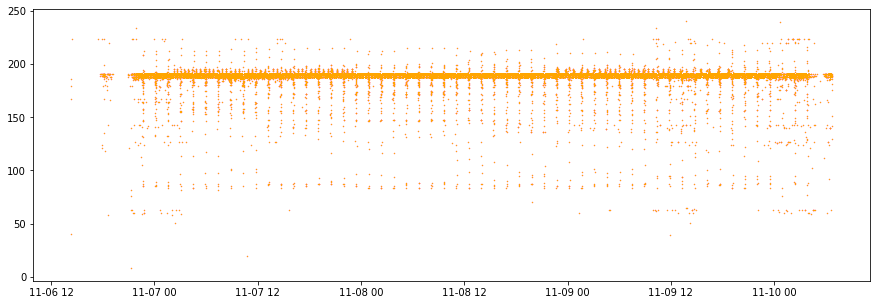

In [92]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_26, '.', markersize=MARKERSIZE, alpha=ALPHA, color=RFI_EXPERIEMNT_DATA_COLOR);

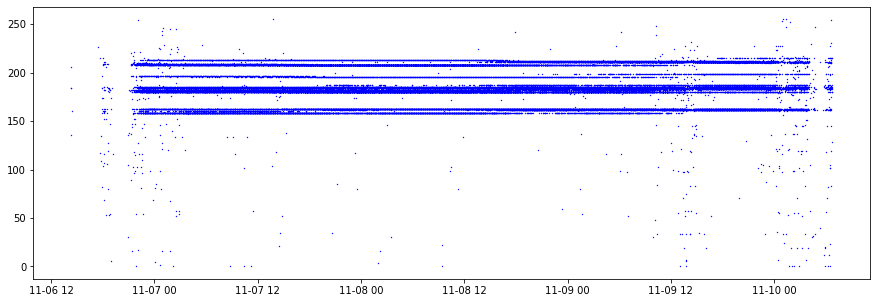

In [93]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_27, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

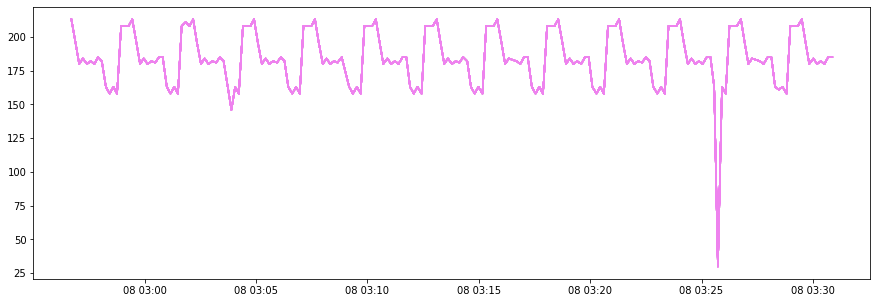

In [94]:
plt.figure(figsize = [X,Y])
plt.plot(t1[10000:10200], frame1_word_27[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

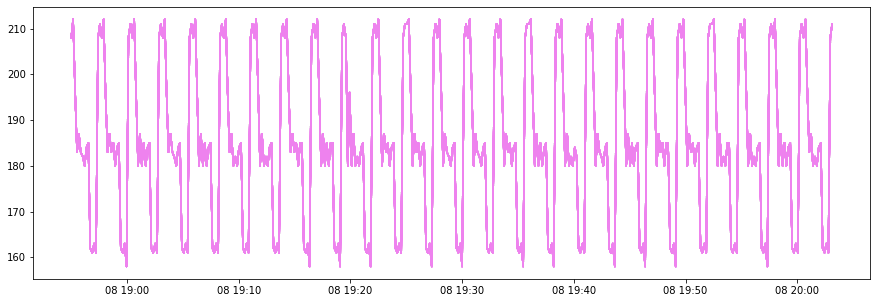

In [95]:
plt.figure(figsize = [X,Y])
plt.plot(t1[15600:16000], frame1_word_27[15600:16000], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

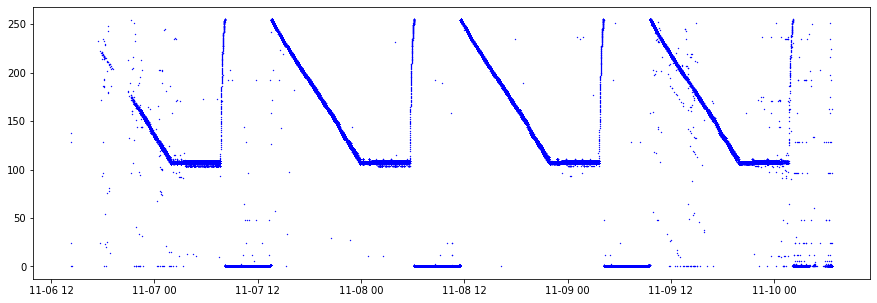

In [96]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_28, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

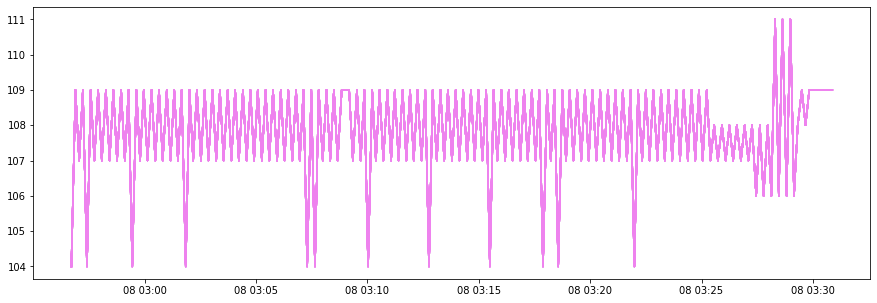

In [97]:
plt.figure(figsize = [X,Y])
plt.plot(t1[10000:10200], frame1_word_28[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

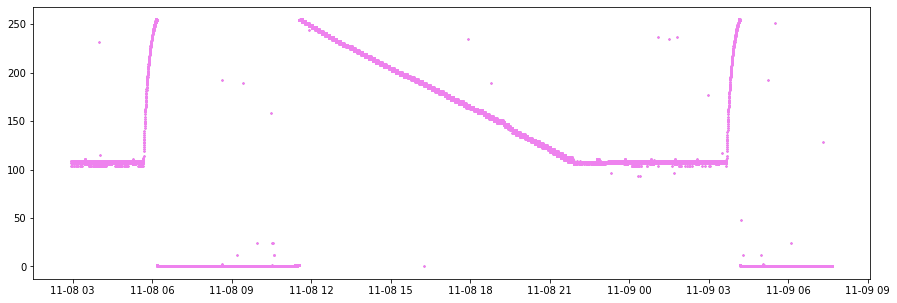

In [98]:
plt.figure(figsize = [X,Y])
plt.plot(t1[10000:20000], frame1_word_28[10000:20000], '.',markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

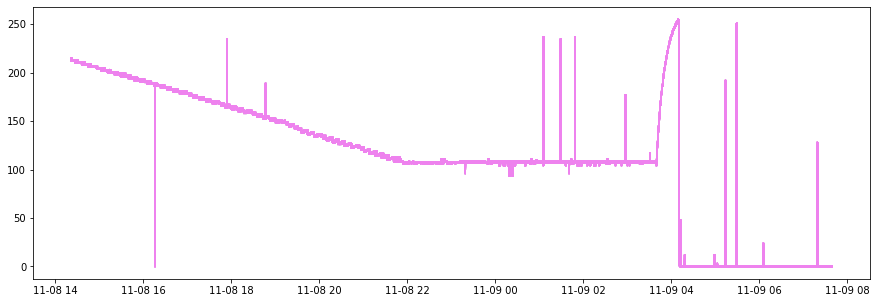

In [99]:
plt.figure(figsize = [X,Y])
plt.plot(t1[14000:20000], frame1_word_28[14000:20000], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

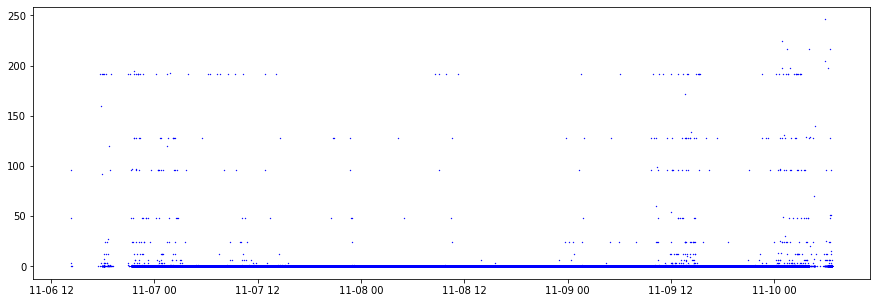

In [100]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_29, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

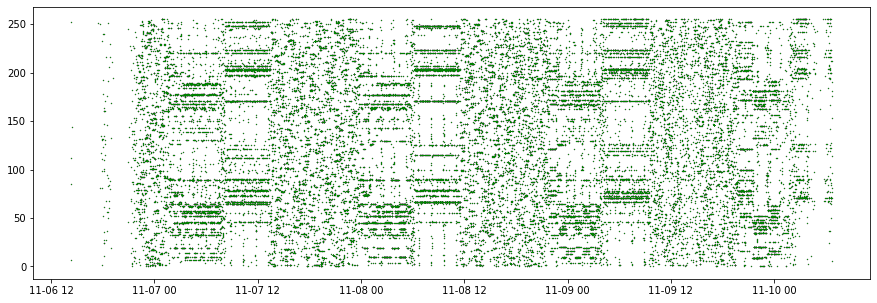

In [101]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_30, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

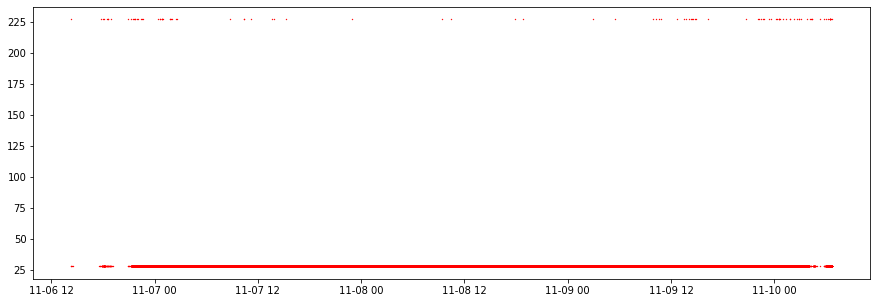

In [102]:
plt.figure(figsize = [X,Y])
plt.plot(t1, frame1_word_31, '.', markersize=MARKERSIZE, alpha=ALPHA, color=SYNC_COLOR);

In [103]:
#FRAME 2 data words
x = 0

frame2_word_0 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_1 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_2 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_3 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_4 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_5 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_6 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_7 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_8 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_9 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_10 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_11 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_12 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_13 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_14 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_15 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_16 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_17 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_18 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_19 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_20 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_21 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_22 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_23 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_24 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_25 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_26 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_27 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_28 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_29 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_30 = np.arange(frame2_count).reshape(frame2_count,1)
frame2_word_31 = np.arange(frame2_count).reshape(frame2_count,1)

for x in range (0,frame2_count):
    frame2_word_0[x] = frame2_words[x,0]
    frame2_word_1[x] = frame2_words[x,1]
    frame2_word_2[x] = frame2_words[x,2]
    frame2_word_3[x] = frame2_words[x,3]
    frame2_word_4[x] = frame2_words[x,4]
    frame2_word_5[x] = frame2_words[x,5]
    frame2_word_6[x] = frame2_words[x,6]
    frame2_word_7[x] = frame2_words[x,7]
    frame2_word_8[x] = frame2_words[x,8]
    frame2_word_9[x] = frame2_words[x,9]
    frame2_word_10[x] = frame2_words[x,10]
    frame2_word_11[x] = frame2_words[x,11]
    frame2_word_12[x] = frame2_words[x,12]
    frame2_word_13[x] = frame2_words[x,13]
    frame2_word_14[x] = frame2_words[x,14]
    frame2_word_15[x] = frame2_words[x,15]
    frame2_word_16[x] = frame2_words[x,16]
    frame2_word_17[x] = frame2_words[x,17]
    frame2_word_18[x] = frame2_words[x,18]
    frame2_word_19[x] = frame2_words[x,19]
    frame2_word_20[x] = frame2_words[x,20]
    frame2_word_21[x] = frame2_words[x,21]
    frame2_word_22[x] = frame2_words[x,22]
    frame2_word_23[x] = frame2_words[x,23]
    frame2_word_24[x] = frame2_words[x,24]
    frame2_word_25[x] = frame2_words[x,25]
    frame2_word_26[x] = frame2_words[x,26]
    frame2_word_27[x] = frame2_words[x,27]
    frame2_word_28[x] = frame2_words[x,28]
    frame2_word_29[x] = frame2_words[x,29]
    frame2_word_30[x] = frame2_words[x,30]
    frame2_word_31[x] = frame2_words[x,31]  
    

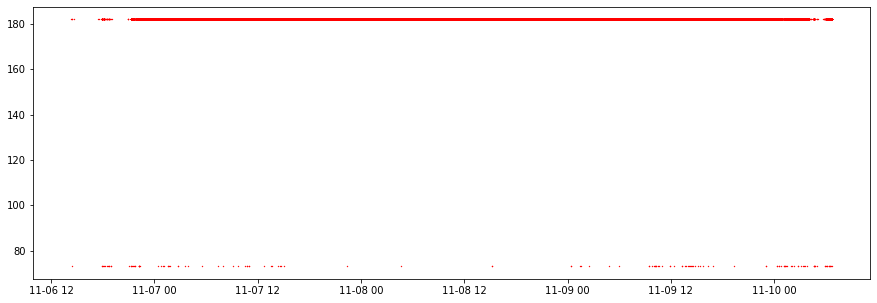

In [104]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_0, '.', markersize=MARKERSIZE, alpha=ALPHA, color=SYNC_COLOR);

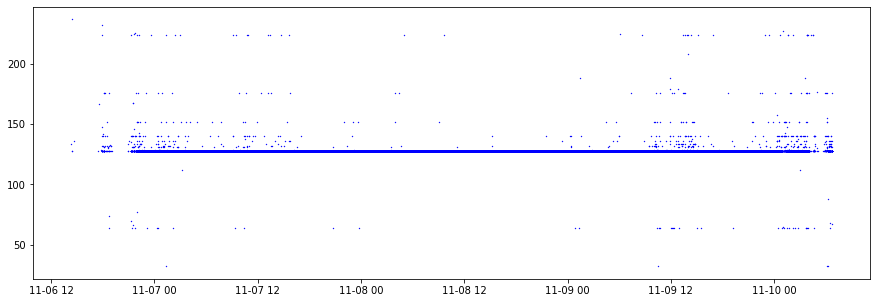

In [105]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_1, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

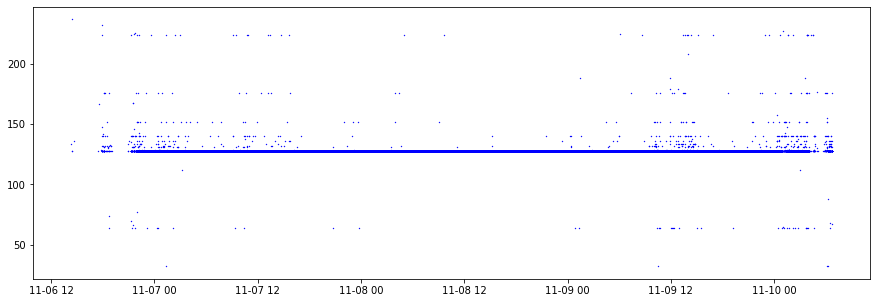

In [106]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_1, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

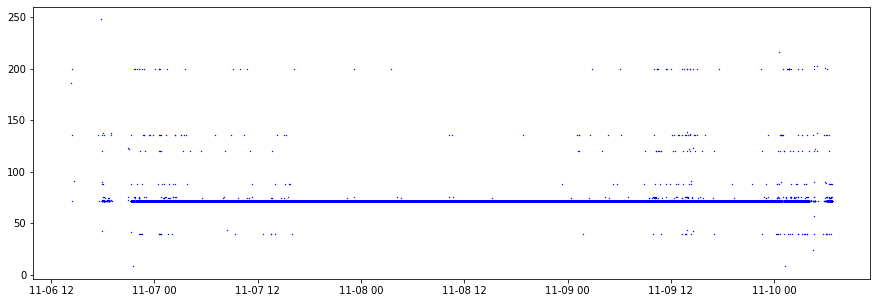

In [107]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_2, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_3, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_4, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_5, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_6, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_7, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2[10000:10200], frame2_word_7[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_8, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_9, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_10, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_11, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2[15600:16000], frame2_word_11[15600:16000], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_12, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_13, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_14, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_15, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_16, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_17, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2[10000:10200], frame2_word_17[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2[15600:16000], frame2_word_17[15600:16000], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_18, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_19, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_20, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_21, '.', markersize=MARKERSIZE, alpha=ALPHA, color=RFI_EXPERIEMNT_DATA_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_22, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2[10000:10200], frame2_word_22[10000:10200], markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_23, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_24, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_25, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_26, '.', markersize=MARKERSIZE, alpha=ALPHA, color=RFI_EXPERIEMNT_DATA_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_27, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);


In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2[10000:10200], frame2_word_27[10000:10200],  markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2[15600:16000], frame2_word_27[15600:16000],  markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_28, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2[10000:10200], frame2_word_28[10000:10200],  markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_29, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_30, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t2, frame2_word_31, '.', markersize=MARKERSIZE, alpha=ALPHA, color=SYNC_COLOR);

In [ ]:
#FRAME 3 data words
x = 0

frame3_word_0 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_1 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_2 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_3 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_4 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_5 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_6 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_7 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_8 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_9 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_10 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_11 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_12 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_13 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_14 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_15 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_16 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_17 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_18 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_19 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_20 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_21 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_22 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_23 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_24 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_25 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_26 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_27 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_28 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_29 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_30 = np.arange(frame3_count).reshape(frame3_count,1)
frame3_word_31 = np.arange(frame3_count).reshape(frame3_count,1)

for x in range (0,frame3_count):
    frame3_word_0[x] = frame3_words[x,0]
    frame3_word_1[x] = frame3_words[x,1]
    frame3_word_2[x] = frame3_words[x,2]
    frame3_word_3[x] = frame3_words[x,3]
    frame3_word_4[x] = frame3_words[x,4]
    frame3_word_5[x] = frame3_words[x,5]
    frame3_word_6[x] = frame3_words[x,6]
    frame3_word_7[x] = frame3_words[x,7]
    frame3_word_8[x] = frame3_words[x,8]
    frame3_word_9[x] = frame3_words[x,9]
    frame3_word_10[x] = frame3_words[x,10]
    frame3_word_11[x] = frame3_words[x,11]
    frame3_word_12[x] = frame3_words[x,12]
    frame3_word_13[x] = frame3_words[x,13]
    frame3_word_14[x] = frame3_words[x,14]
    frame3_word_15[x] = frame3_words[x,15]
    frame3_word_16[x] = frame3_words[x,16]
    frame3_word_17[x] = frame3_words[x,17]
    frame3_word_18[x] = frame3_words[x,18]
    frame3_word_19[x] = frame3_words[x,19]
    frame3_word_20[x] = frame3_words[x,20]
    frame3_word_21[x] = frame3_words[x,21]
    frame3_word_22[x] = frame3_words[x,22]
    frame3_word_23[x] = frame3_words[x,23]
    frame3_word_24[x] = frame3_words[x,24]
    frame3_word_25[x] = frame3_words[x,25]
    frame3_word_26[x] = frame3_words[x,26]
    frame3_word_27[x] = frame3_words[x,27]
    frame3_word_28[x] = frame3_words[x,28]
    frame3_word_29[x] = frame3_words[x,29]
    frame3_word_30[x] = frame3_words[x,30]
    frame3_word_31[x] = frame3_words[x,31]  
    

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_0, '.', markersize=MARKERSIZE, alpha=ALPHA, color=SYNC_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_1, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_2, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_3, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_4, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_5, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_6, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3[10000:10200], frame3_word_6[10000:10200],  markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_7, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_8, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3[15600:16000], frame3_word_8[15600:16000], '.',  markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_9, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_10, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_11, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_12, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_13, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_14, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_15, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_16, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_17, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_18, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3[10000:10100], frame3_word_27[10000:10100],  markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3[15600:16000], frame3_word_18[15600:16000],  markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_19, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_20, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_21, '.', markersize=MARKERSIZE, alpha=ALPHA, color=RFI_EXPERIEMNT_DATA_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_22, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_23, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_24, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_25, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_26, '.', markersize=MARKERSIZE, alpha=ALPHA, color=RFI_EXPERIEMNT_DATA_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_27, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3[15600:16000], frame3_word_27[15600:16000],  markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_28, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3[10000:16000], frame3_word_28[10000:16000],  markersize=1, alpha=10, color=ZOOMED_DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_29, '.', markersize=MARKERSIZE, alpha=ALPHA, color=DATA_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_30, '.', markersize=MARKERSIZE, alpha=ALPHA, color=ERROR_DETECTION_WORD_COLOR);

In [ ]:
plt.figure(figsize = [X,Y])
plt.plot(t3, frame3_word_31, '.', markersize=MARKERSIZE, alpha=ALPHA, color=SYNC_COLOR);